# **BioImage Model Zoo Example notebook**

---

This notebook provides examples of how to load pretrained deep learning models from [BioImage Model Zoo](https://bioimage.io) and use them to process new images.

## **1. Install key dependencies**
---
<font size = 4>


### **1.1. Install required dependencies**

---

In [ ]:
#@markdown ##Play to install dependencies
#@markdown #### DO NOT RESTART THE SESSION UNTIL THE CELL FINISHES RUNNING
#@markdown #### This may take few minutes

!pip install -q bioimageio.core==0.6.8
!pip install -q matplotlib==3.9.0
!pip install -q imageio==2.31.2
!pip install -q numpy==1.23.5
!pip install -q torch==2.2.0
!pip install -q onnxruntime==1.18.0
!pip install -q pooch==1.8
!pip install -q marshmallow==3.21.3

### **1.2. Connect to your Google Drive to access training data**

---

In [ ]:
#@markdown ## Run this cell to connect Google Drive

from google.colab import drive
drive.mount('/content/drive')

### **1.3. Load BioImageIO dependencies**

---

In [ ]:
#@markdown ##Play to load the dependencies and functions

# If you'd rather read the warning messages, please comment the follwing two lines.
import warnings
warnings.filterwarnings("ignore")

# Load BioImage Model Zoo packages
from bioimageio.core.digest_spec import create_sample_for_model
from bioimageio.core import predict, create_prediction_pipeline, load_description, test_model

import bioimageio.spec
from bioimageio.spec import save_bioimageio_package
from bioimageio.spec.utils import load_array, download
from bioimageio.spec.model.v0_5 import (ModelDescr, ArchitectureFromFileDescr, Author, CiteEntry,
                                        Version, Doi, HttpUrl, LicenseId,
                                        WeightsDescr, PytorchStateDictWeightsDescr, TorchscriptWeightsDescr,
                                        InputTensorDescr, OutputTensorDescr, TensorId, LinkedDataset,
                                        FileDescr, IntervalOrRatioDataDescr, Identifier, SizeReference,
                                        BatchAxis, ChannelAxis, SpaceInputAxis, SpaceOutputAxis)


# Load other packages
import matplotlib.pyplot as plt
import numpy as np
import pooch
import json
import os

from IPython.display import display, Markdown
from imageio import imwrite as imsave
from imageio import imread
from pathlib import Path
from ruyaml import YAML

# URL pointing the file with the collection from the BIoimage Model Zoo
COLLECTION_URL = "https://raw.githubusercontent.com/bioimage-io/collection-bioimage-io/gh-pages/collection.json"

# Download the colection
collection_path = Path(pooch.retrieve(COLLECTION_URL, known_hash=None))
with collection_path.open() as f:
    collection = json.load(f)

# Get all the URLs of the models in the downloaded collection
model_urls = [entry["rdf_source"] for entry in collection["collection"] if entry["type"] == "model"]

# Download the rdf.yaml files from all the folders
yaml = YAML(typ="safe")
model_rdfs = [yaml.load(Path(pooch.retrieve(mu, known_hash=None))) for mu in model_urls]

# Get only the models that have "pytorch_state_dict" weights
pytorch_models = [rdf for rdf in model_rdfs if "pytorch_state_dict" in rdf["weights"]]


## **2. Inspect a model from the BioImage Model Zoo**

---

Here we will guide you through the basic functionalities of the BioImageIO Python package to interact with the content in the BioImage Model Zoo.

In the following cell you will get a list of available models in PyTorch.

In [ ]:
#@markdown ##Check the models that can be loaded for PyTorch

# Print all the PyTorch models ("pytorch_state_dict" weights) on the Bioimage Model Zoo
print('List of models for PyTorch:\n')
for model in pytorch_models:
    print(f"{model['name']}\n - {model['config']['bioimageio']['nickname']}\n - {model['config']['bioimageio']['doi']}")

List of models for PyTorch:

NucleiSegmentationBoundaryModel
 - affable-shark
 - 10.5281/zenodo.6647674
LiveCellSegmentationBoundaryModel
 - hiding-tiger
 - 10.5281/zenodo.6647688
Neuron Segmentation in EM (Membrane Prediction)
 - impartial-shrimp
 - 10.5281/zenodo.5874742
EnhancerMitochondriaEM2D
 - hiding-blowfish
 - 10.5281/zenodo.6811922
MitochondriaEMSegmentationBoundaryModel
 - kind-seashell
 - 10.5281/zenodo.6630266
PlatynereisEMnucleiSegmentationBoundaryModel
 - organized-badger
 - 10.5281/zenodo.6028098
PlatynereisEMcellsSegmentationBoundaryModel
 - willing-hedgehog
 - 10.5281/zenodo.6647695
3D UNet Arabidopsis Apical Stem Cells
 - emotional-cricket
 - 10.5281/zenodo.7768142
CovidIFCellSegmentationBoundaryModel
 - powerful-chipmunk
 - 10.5281/zenodo.6647683
MitchondriaEMSegmentation2D
 - shivering-raccoon
 - 10.5281/zenodo.6406804
3D UNet Mouse Embryo Live
 - powerful-fish
 - 10.5281/zenodo.7774490
3D UNet Mouse Embryo Fixed
 - loyal-squid
 - 10.5281/zenodo.7774505
EpitheliaAf

### **2.1. Load the resource description specifications of the model**

---

To load a model of your choice, you only need to write one of the following ones in the cell and leave the rest empty.

<font size = 3>**`BMZ_MODEL_ID`**: Unique identifier of the model to load in the BioImage Model Zoo, e.g., `impartial-shrimp`. These identifiers are given on each model card in the zoo.

OR

<font size = 3>**`BMZ_MODEL_DOI`**: Model DOIs can also be used to load the models.

OR

<font size = 3>**`BMZ_MODEL_URL`**: URL to the main Zenodo repository as well as to the `rdf.yaml` file containing the resource description specifications can be used to load models as well.

In [ ]:
#@markdown ##Load the model description with one of these options

# "affable-shark"
BMZ_MODEL_ID = "" #@param {type:"string"}
# "10.5281/zenodo.5764892"
BMZ_MODEL_DOI = "" #@param {type:"string"}
# "https://uk1s3.embassy.ebi.ac.uk/public-datasets/bioimage.io/affable-shark/1.1/files/rdf.yaml"
BMZ_MODEL_URL = "https://uk1s3.embassy.ebi.ac.uk/public-datasets/bioimage.io/affable-shark/1.1/files/rdf.yaml" #@param {type:"string"}

#####
# Load the model description from one of the provided options

if BMZ_MODEL_ID != "":
    model = load_description(BMZ_MODEL_ID)  # TODO: load from bioimageio id
    print(f"The model '{model.name}' with ID '{BMZ_MODEL_ID}' has been correctly loaded.")
elif BMZ_MODEL_DOI != "":
    model = load_description(BMZ_MODEL_DOI)
    print(f"The model '{model.name}' with DOI '{BMZ_MODEL_DOI}' has been correctly loaded.")
elif BMZ_MODEL_URL != "":
    model = load_description(BMZ_MODEL_URL)
    print(f"The model '{model.name}' with URL '{BMZ_MODEL_URL}' has been correctly loaded.")
else:
    print('Please specify a model ID, DOI or URL')

computing SHA256 of 3c123c5162a87c48333c80f7389e99a7-zero_mean_unit_variance.ijm (result: 767f2c3a50e36365c30b9e46e57fcf82e606d337e8a48d4a2440dc512813d186): 100%|██████████| 1/1 [00:00<00:00, 2743.17it/s] 
computing SHA256 of 93e503596d7d0bbf5b3937cf1a80402b-test_input_0.npy (result: c29bd6e16e3f7856217b407ba948222b1c2a0da41922a0f79297e25588614fe2): 100%|██████████| 3/3 [00:00<00:00, 6570.71it/s] 
computing SHA256 of baeb9b3639733aa6ad5f8305149a3585-sample_input_0.tif (result: a24b3c708b6ca6825494eb7c5a4d221335fb3eef5eb9d03f4108907cdaad2bf9): 100%|██████████| 1/1 [00:00<00:00, 4471.54it/s] 
computing SHA256 of 858a63339bdb8f80ff310e077a5079bb-test_output_0.npy (result: 510181f38930e59e4fd8ecc03d6ea7c980eb6609759655f2d4a41fe36108d5f5): 100%|██████████| 5/5 [00:00<00:00, 11702.86it/s]
computing SHA256 of d22d18e9c3592839985cac2534ac4617-sample_output_0.tif (result: e8f99aabe8405427f515eba23a49f58ba50302f57d1fdfd07026e1984f836c5e): 100%|██████████| 5/5 [00:00<00:00, 10543.75it/s]
computin

The model 'NucleiSegmentationBoundaryModel' with URL 'https://uk1s3.embassy.ebi.ac.uk/public-datasets/bioimage.io/affable-shark/1.1/files/rdf.yaml' has been correctly loaded.


### **2.2. Discover the different components and features of the model**

---

#### Print information about the model

The model 'NucleiSegmentationBoundaryModel 🦈' had the following properties and metadata:

 Description: Nucleus segmentation for fluorescence microscopy
 Tags: fluorescence-light-microscopy, nuclei, instance-segmentation, unet, 2d
 Model ID: 10.5281/zenodo.5764892/6647674

 The authors of the model are:
  - Constantin Pape, with GitHub user: @constantinpape
 The maintainers of the modes are:
  - Constantin Pape, with GitHub user: @constantinpape

 License: CC-BY-4.0

 If you use this model, you are expected to cite:
  - For the training library, from DOI (https://doi.org/10.5281/zenodo.5108853)
  - For the architecture, from DOI (https://doi.org/10.1007/978-3-319-24574-4_28)
  - For the segmentation algorithm, from DOI (https://doi.org/10.1038/nmeth.4151)
  - For the data, from URL (https://www.nature.com/articles/s41592-019-0612-7)

 Covers of the model 'NucleiSegmentationBoundaryModel' are: 


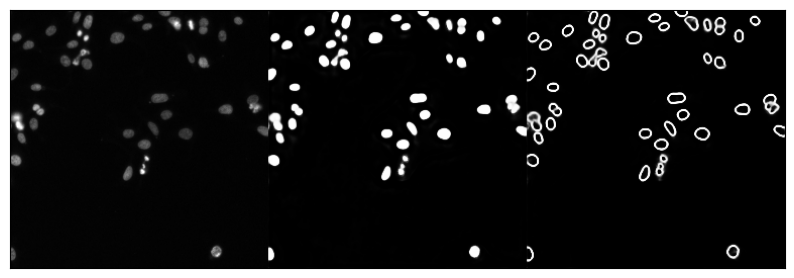


 Further documentation (taken from https://uk1s3.embassy.ebi.ac.uk/public-datasets/bioimage.io/affable-shark/1.1/files/documentation.md):
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


# U-Net for Nucleus Segmentation

This model segments nuclei in fluorescence microscopy images.
It predicts boundary maps and foreground probabilities for nucleus segmentation in
different light microscopy modalities, mainly with DAPI staining.
The boundaries can be processed e.g. with Multicut or Watershed to obtain an instance segmentation.

## Training

The network was trained on data from the Data Science Bowl Nucleus Segmentation Challenge.
The training script can be found [here](https://github.com/constantinpape/torch-em/tree/main/experiments/dsb).
This folder also includes example usages of this model.

### Training Data

- Imaging modality: different fluorescence light microscopy modalities.
- Dimensionality: 2D
- Source: DSB Kaggle Challenge

### Recommended Validation

It is recommended to validate the instance segmentation obtained from this model using intersection-over-union.
See [the validation script](https://github.com/constantinpape/torch-em/tree/main/experiments/dsb/validate_model.py).
This model can also be used in ilastik, deepimageJ or other software that supports the bioimage.io model format.

### Training Schedule

n_epochs: 1458
batches_per_epoch: 56
batch_size: 8
loss_function: DiceLoss
optimizer: Adam
learning_rate: 0.0001
n_train_images: 447
n_validation_images: 50

## Contact

For questions or issues with this models, please reach out by:
- opening a topic with tags bioimageio and nucleisegmentationboundarymodel on [image.sc](https://forum.image.sc/)
- or creating an issue in https://github.com/constantinpape/torch-em

 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -


In [ ]:
#@markdown ##Print information about the model

print(f"The model '{model.name} {model.id_emoji}' had the following properties and metadata:")
print()
print(f" Description: {model.description}")
print(f" Tags: {', '.join(model.tags)}")
print(f" Model ID: {model.id}")
print()
print(f" The authors of the model are:")
for author in model.authors:
    print(f"  - {author.name}, with GitHub user: @{author.github_user}")
print(f" The maintainers of the modes are:")
for maintainer in model.maintainers:
    print(f"  - {maintainer.name}, with GitHub user: @{maintainer.github_user}")
print()
print(f" License: {model.license}")
print()
print(f" If you use this model, you are expected to cite:")
for citation in model.cite:
    doi_text = ""
    if citation.doi is not None:
        doi_text = f" from DOI (https://doi.org/{citation.doi})"

    url_text = ""
    if citation.url is not None:
        if citation.doi is not None:
            url_text = f" or URL ({citation.url})"
        else:
            url_text = f" from URL ({citation.url})"
    print(f"  - For the {citation.text},{doi_text}{url_text}")
if model.git_repo is not None:
    print()
    print(f" GitHub repository: {model.git_repo}")
print()
print(f" Covers of the model '{model.name}' are: ")
for cover in model.covers:
    cover_data = imread(download(cover).path)
    plt.figure(figsize=(10, 10))
    plt.imshow(cover_data)
    plt.xticks([])
    plt.yticks([])
    plt.show()
print()
print(f" Further documentation (taken from {model.documentation.absolute()}):")
print(' -'*60)
display(Markdown(open(download(model.documentation).path).read()))
print(' -'*60)

#### Inspect the weights and, expected inputs and outputs

In [ ]:
#@markdown ##Inspect the weights and, expected inputs and outputs

print("Available weight formats for this model:", ", ".join(model.weights.model_fields_set))
print("Pytorch state dict weights are stored at:", model.weights.pytorch_state_dict.source.absolute())
print()

# or what inputs the model expects
print(f"The model requires {len(model.inputs)} input(s) with the following features:")
for inp in model.inputs:
    print(" - Input with axes:", ([i.id for i in inp.axes]))
    print(" - Minimum shape:", ([s.min if type(s) is bioimageio.spec.model.v0_5.ParameterizedSize else s for s in inp.shape]))
    print(" - Step:", ([s.step if type(s) is bioimageio.spec.model.v0_5.ParameterizedSize else s for s in inp.shape]))
    print()
    print(f"It is expected to be processed with:")
    for prep in inp.preprocessing:
        print(f" - '{prep.id}' with arguments:")
        for prerp_arg in prep.kwargs:
           print(f"    - {prerp_arg[0]}={prerp_arg[1]}")
print()
# and what the model outputs are
print(f"The model gives {len(model.outputs)} output(s) with the following features:")
for out in model.outputs:
    print(" - Output with axes:", ([o.id for o in out.axes]) )
    print(" - Minimum shape:", ([s if type(s) is bioimageio.spec.model.v0_5.SizeReference else s for s in out.shape]))
    print(" - Step:", ([s.step if type(s) is bioimageio.spec.model.v0_5.ParameterizedSize else s for s in out.shape]))
    print()
    print(f"It is expected to be processed with:")
    for postp in out.postprocessing:
        print(f" - '{postp.id}' with arguments:")
        for postp_arg in postp.kwargs:
           print(f"    - {postp_arg[0]}={postp_arg[1]}")
    #print(f"The output image has a halo of : {out.halo}")


Available weight formats for this model: onnx, pytorch_state_dict, torchscript
Pytorch state dict weights are stored at: https://uk1s3.embassy.ebi.ac.uk/public-datasets/bioimage.io/affable-shark/1.1/files/weights.pt

The model requires 1 input(s) with the following features:
 - Input with axes: ['batch', 'channel', 'y', 'x']
 - Minimum shape: [None, 1, 64, 64]
 - Step: [None, 1, 16, 16]

It is expected to be processed with:
 - 'ensure_dtype' with arguments:
    - dtype=float32
 - 'zero_mean_unit_variance' with arguments:
    - axes=['channel', 'y', 'x']
    - eps=1e-06
 - 'ensure_dtype' with arguments:
    - dtype=float32

The model gives 1 output(s) with the following features:
 - Output with axes: ['batch', 'channel', 'y', 'x']
 - Minimum shape: [None, 2, SizeReference(tensor_id='input0', axis_id='y', offset=0), SizeReference(tensor_id='input0', axis_id='x', offset=0)]
 - Step: [None, 2, SizeReference(tensor_id='input0', axis_id='y', offset=0), SizeReference(tensor_id='input0', axis_

#### Inspect the test images

The model provides 1 test input image(s) :


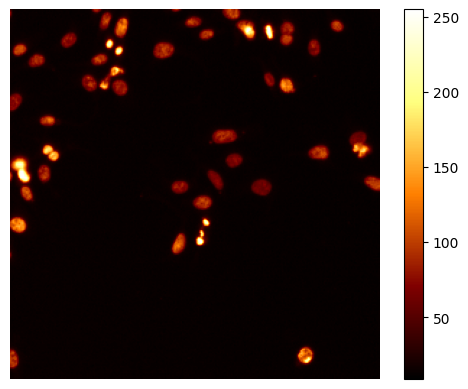

The model provides 1 test output image(s) :
The test output image has shape (2, 256, 256), so it will not displayed


In [ ]:
#@markdown ##Inspect the test images

# Inspect the test input images provided within the model
print(f"The model provides {len(model.inputs)} test input image(s) :")
for test_im in model.get_input_test_arrays():
    test_input = np.squeeze(test_im)
    if len(test_input.shape)>2:
        print(f"The test input image has shape {test_input.shape}, so it will not displayed")
    else:
        fig, ax = plt.subplots()
        im = ax.imshow(test_input, cmap="afmhot")
        fig.colorbar(im)
        ax.set_axis_off()
        plt.show()

# Inspect the test output images provided within the model
print(f"The model provides {len(model.outputs)} test output image(s) :")
for test_im in model.get_output_test_arrays():
    test_output = np.squeeze(test_im)
    if len(test_output.shape)>2:
        print(f"The test output image has shape {test_output.shape}, so it will not displayed")
    else:
        fig, ax = plt.subplots()
        im = ax.imshow(test_output, cmap="afmhot")
        fig.colorbar(im)
        ax.set_axis_off()
        plt.show()

## **3. Test the model**

---

Both the model format and the deployment of the model can be tested.

By running the following cell you can check that
- The model follows the format of the BioImage Model Zoo correctly (static validation)
- It actually produces the output that is expected to produce (dynamic validation). This is done by running a prediction for the test input images and checking that they agree with the given test output(s).

The running time depends on the resources available (e.g., GPU acceleration).

In [ ]:
#@markdown ##Check if the model pass the test

# Test the description of the model
test_result = test_model(model)

# 'test_model()' returns a ValidationSummary object with an attribute status which can be 'passed'/'failed' and more detailed information
if test_result.status == "failed":
    print("model test:", test_result.name)
    if len(test_result.errors) > 1:
        print("The model test failed with many errors (we are only showing the first one):")
    else:
        print("The model test failed with:")
    for error in test_result.errors[:1]:
        # Allowing a good indexation in the message
        error_msg = error.msg.split('\n')
        print(f" - {error_msg[0]}")
        for line in error_msg[1:]:
            print(f"   {line}")
else:
    print("model test:", test_result.name)
    assert test_result.status == "passed", f"Something went wrong, test_result.status is {test_result.status} and should be 'passed'."
    print("The model passed the test.")
    print()

# Get the versions of the Bioimage.IO packages used for this test
bioimageio_spec_version = ""
bioimageio_core_version = ""
for package in test_result.env:
    if package['name'] == 'bioimageio.spec':
        bioimageio_spec_version = package['version']
    if package['name'] == 'bioimageio.core':
        bioimageio_core_version = package['version']

print()
print(f"The model was tested using:")
print(f" - 'bioimageio_spec_version': '{bioimageio_spec_version}'")
print(f" - 'bioimageio_core_version': '{bioimageio_core_version}'")

2024-08-12 14:19:10.239 | INFO     | bioimageio.core._resource_tests:_test_model_inference:130 - starting 'Reproduce test outputs from test inputs'
2024-08-12 14:19:10.608 | INFO     | bioimageio.core._resource_tests:_test_model_inference_parametrized:215 - Testing inference with 6 different input tensor sizes
2024-08-12 14:19:10.814 | INFO     | bioimageio.core._resource_tests:_test_model_inference:130 - starting 'Reproduce test outputs from test inputs'
2024-08-12 14:19:12.007 | INFO     | bioimageio.core._resource_tests:_test_model_inference_parametrized:215 - Testing inference with 6 different input tensor sizes
2024-08-12 14:19:12.443 | INFO     | bioimageio.core._resource_tests:_test_model_inference:130 - starting 'Reproduce test outputs from test inputs'
2024-08-12 14:19:12.627 | INFO     | bioimageio.core._resource_tests:_test_model_inference_parametrized:215 - Testing inference with 6 different input tensor sizes


model test: bioimageio validation
The model test failed with many errors (we are only showing the first one):
 - [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: input.1 for the following indices
    index: 2 Got: 64 Expected: 256
    index: 3 Got: 64 Expected: 256
    Please fix either the inputs/outputs or the model.

The model was tested using:
 - 'bioimageio_spec_version': '0.5.3.2'
 - 'bioimageio_core_version': '0.6.8'


## **4. Use the model with new images**

---

### **4.1. Process an input array**

---

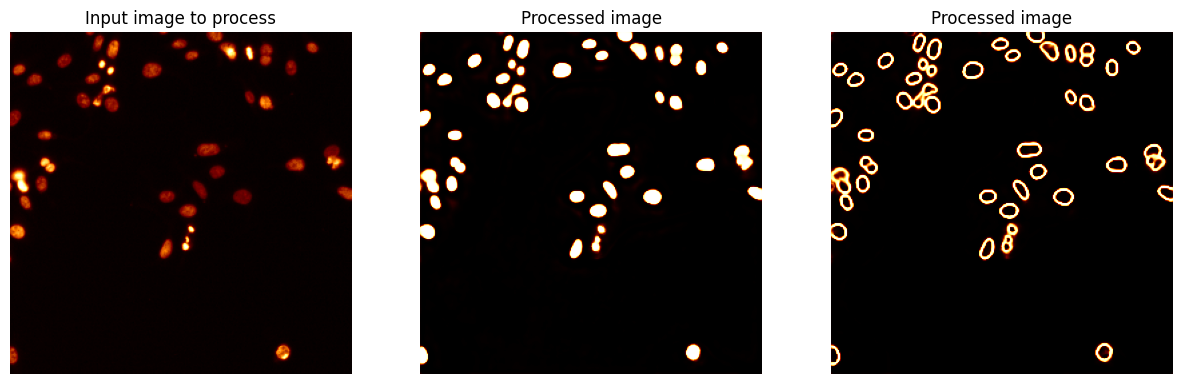

In [ ]:
#@markdown ##Process the input within the model

# Load the example image for this model
input_paths = {ipt.id: download(ipt.test_tensor).path for ipt in model.inputs}
# The prediction pipeline expects a Sample object from bioimageio.core
input_sample = create_sample_for_model(
    model=model, inputs=input_paths, sample_id="my_demo_sample"
)

# "devices" can be used to run prediction on a gpu instead of the cpu
devices = None
# "weight_format" to specify which weight format to use in case the model contains different weight formats
weight_format = None

# The prediction pipeline combines preprocessing, prediction and postprocessing.
# It should always be used for prediction with a bioimageio model.
prediction_pipeline = create_prediction_pipeline(
    model, devices=devices, weight_format=weight_format
)

# The prediction pipeline call expects the same number of inputs as the number of inputs required by the model
# In this case, the model just expects a single input. In case you have multiple inputs use:
# prediction = pred_pipeline(input1, input2, ...)
# or, if you have the inputs in a list or tuple
# prediction = pred_pipeline(*inputs)
# The call returns a list of output tensors, corresponding to the output tensors of the model
prediction = prediction_pipeline.predict_sample_without_blocking(input_sample)

# Convert both input and output sample tensors into a NumPy format to plot them
input_sample_tensor = input_sample.members["input0"].data
input_sample_tensor = np.squeeze(input_sample_tensor)
prediction_tensor = prediction.members["output0"].data
prediction_tensor = np.squeeze(prediction_tensor)

# Plot the input and output images
if len(prediction_tensor.shape)>2:
    subplot_n = prediction_tensor.shape[0]
    plt.figure(figsize=(15,10))
    plt.subplot(1,1+subplot_n,1)
    plt.imshow(input_sample_tensor, cmap="afmhot")
    plt.axis('off')
    plt.title("Input image to process")

    for i in range(subplot_n):
        plt.subplot(1,1+subplot_n,i+2)
        plt.imshow(prediction_tensor[i], cmap="afmhot")
        plt.axis('off')
        plt.title("Processed image")
    plt.show()
else:
    plt.figure(figsize=(5,5))
    plt.subplot(1,2,1)
    plt.imshow(input_sample_tensor, cmap="afmhot")
    plt.axis('off')
    plt.title("Input image to process")
    plt.subplot(1,2,2)
    plt.imshow(prediction_tensor, cmap="afmhot")
    plt.axis('off')
    plt.title("Processed image")
    plt.show()

### **4.2. Process an image from a directory and save the result**

---

The BioImageIO is equipped with the utility function `predict` to run prediction with an image stored on disc. The filepath where the output should be stored (`save_outputs`), supports most common image formats (`.tif`, `.png`) as well as `npy` fileformat.

Provide the path to the image to be processes in `path2image` or run it with the example image.

Predicted images correctly saved on: /home/ocb/Desktop


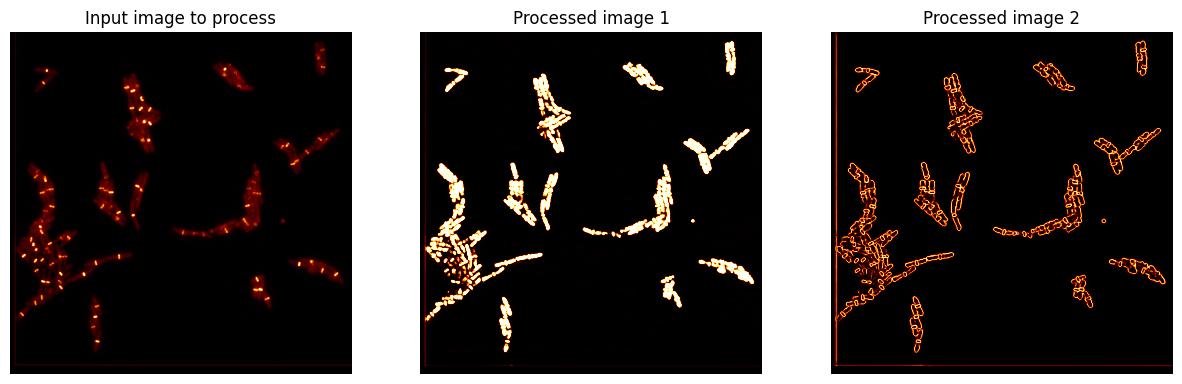

In [ ]:
#@markdown ##Indicate the path to the image

# You might want to use the test images (like on section 4.1.)
use_test_image = False #@param {type:"boolean"}

#@markdown ### If you have an image in a folder to segment, copy the path to it here:
path2image = "/home/ocb/Documents/IH/DeepBacs/Multilabel_U-Net_dataset_B.subtilis/test/source/test_9.tif"  #@param {type:"string"}
#@markdown ### Indicate where to save the output of the model:s
save_outputs = "/home/ocb/Desktop"  #@param {type:"string"}

# Create the result/output folder
os.makedirs(save_outputs, exist_ok=True)

if use_test_image:
  # Download and take the input paths from the model description
  input_paths = {ipt.id: download(ipt.test_tensor).path for ipt in model.inputs}
else:
  # Load the paths to the input images
  input_paths = {"input0": Path(path2image)}

# The prediction pipeline expects a Sample object from bioimageio.core
input_sample = create_sample_for_model(
    model=model, inputs=input_paths, sample_id="my_demo_sample"
)

# Use the predict function with the defined Samples
prediction = predict(model=model, inputs=input_sample)

# Convert both input and output sample tensors into a NumPy format to save and plot them
input_sample_tensor = input_sample.members["input0"].data
input_sample_tensor = np.squeeze(input_sample_tensor)
prediction_tensor = prediction.members["output0"].data
prediction_tensor = np.squeeze(prediction_tensor)

# Save the output results
filename = path2image.split(os.sep)[-1]
name, extenstion = filename.split('.')
for i, f in enumerate(prediction_tensor):
  imsave(uri=os.path.join(save_outputs, f"{name}_{i}.{extenstion}"), im=f)
print(f"Predicted images correctly saved on: {save_outputs}")

# Plot the input image and the predicted results
plt.figure(figsize=(15,15))
plt.subplot(1,1+prediction_tensor.shape[0],1)
plt.imshow(np.squeeze(input_sample_tensor), cmap="afmhot")
plt.axis('off')
plt.title("Input image to process")

for pred_idx, pred in enumerate(prediction_tensor):
    plt.subplot(1,1+prediction_tensor.shape[0],pred_idx+2)
    plt.imshow(pred, cmap="afmhot")
    plt.axis('off')
    plt.title(f"Processed image {pred_idx+1}")
plt.show()



### **4.3. Process a set of images stored in a directory**

---
It is possible to provide a list of images to analyse and run the analysis automatically. In this analysis `padding` and `tiling` strategies are enabled.

Provided directory contains 1 images to predict.


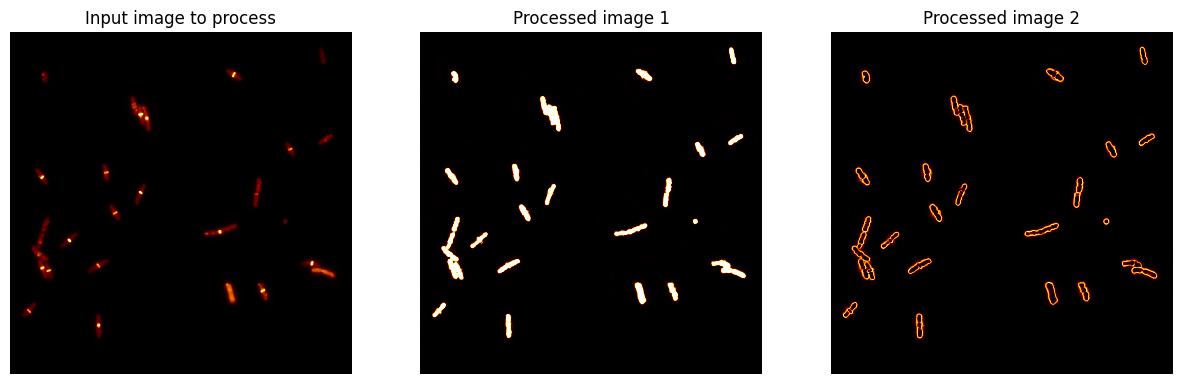

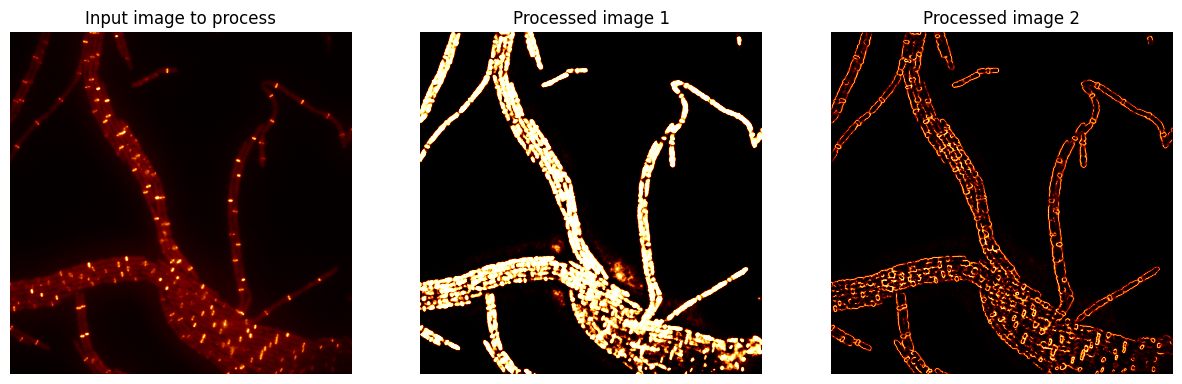

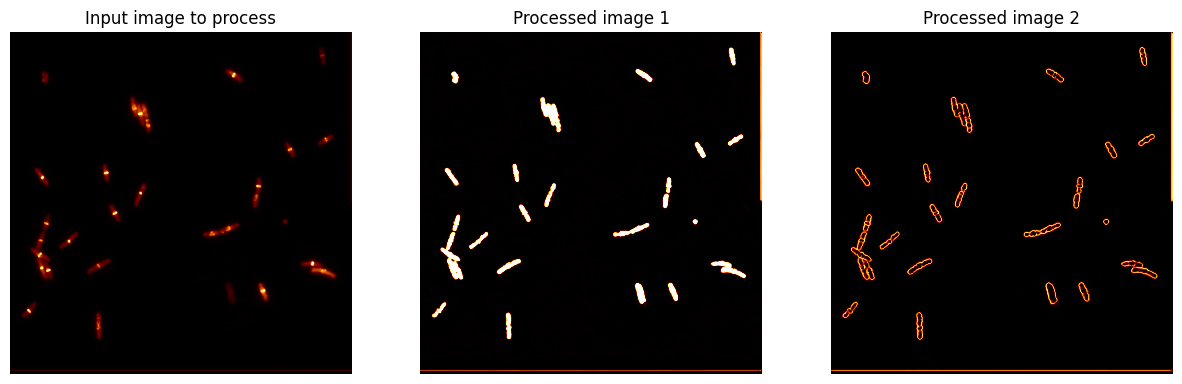

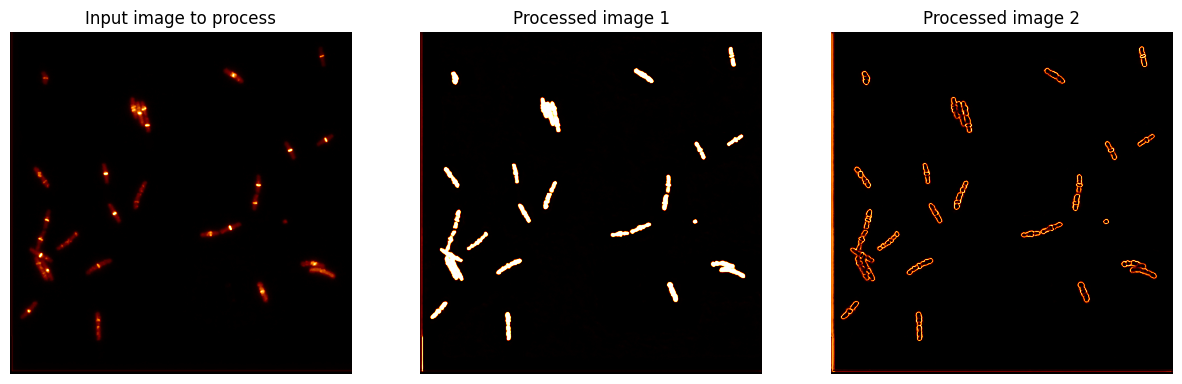

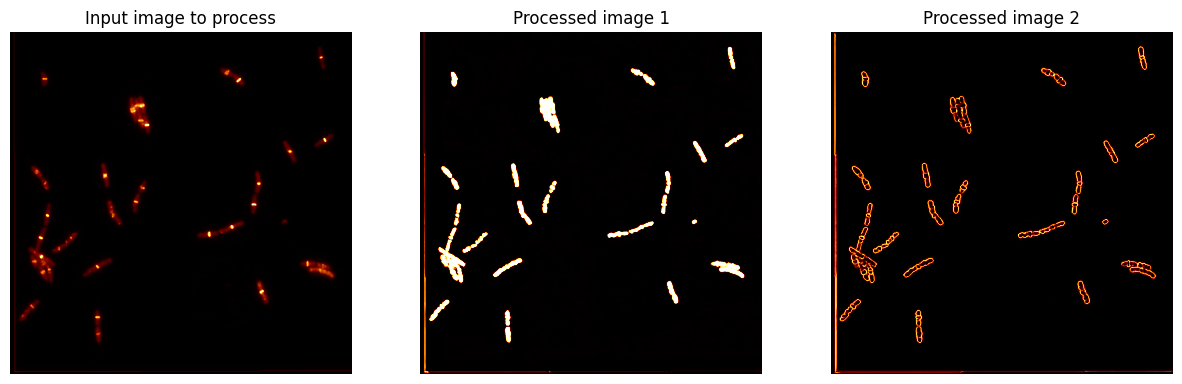

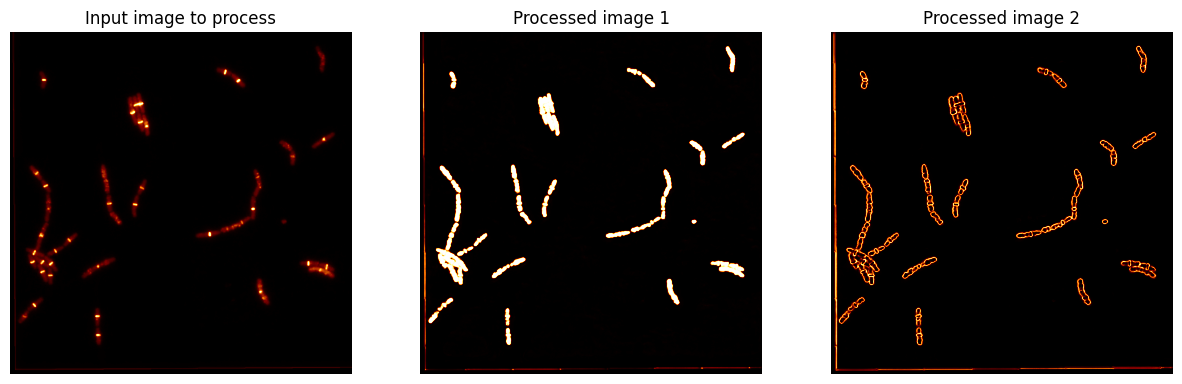

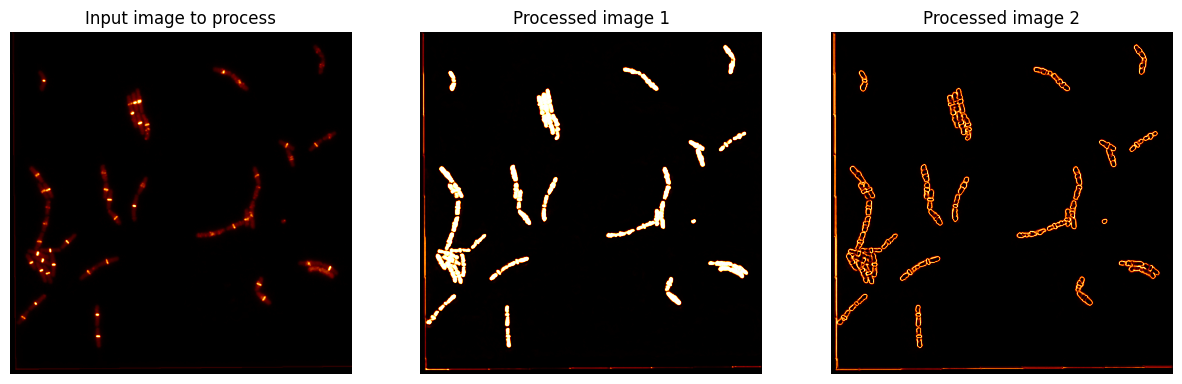

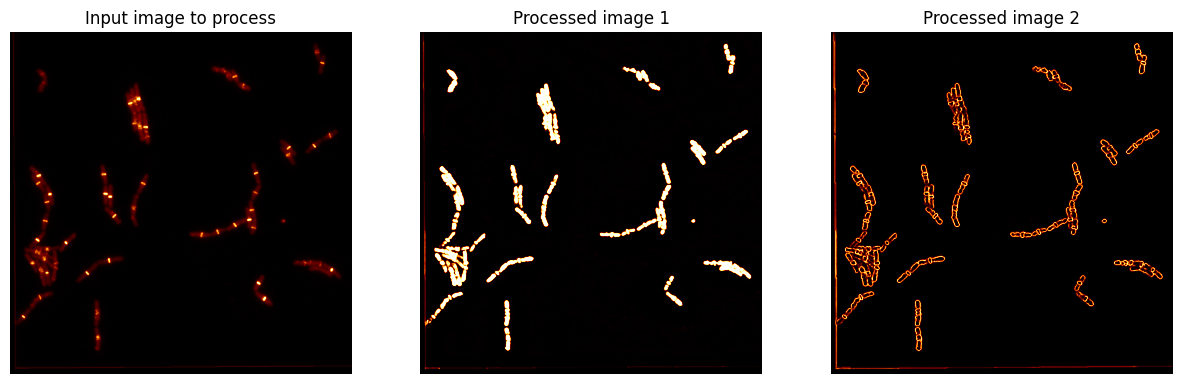

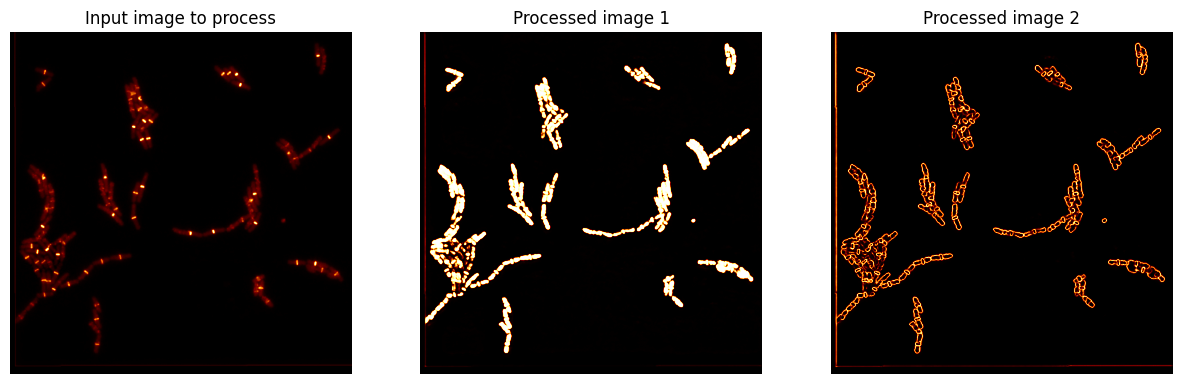

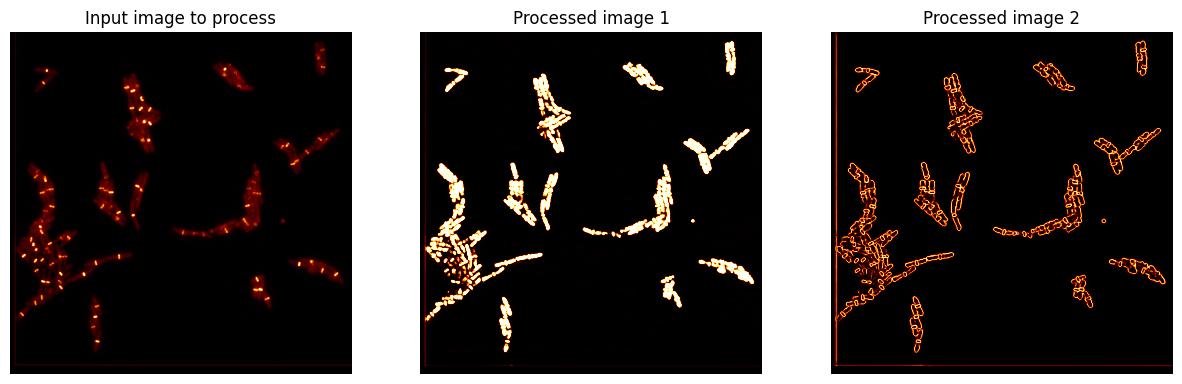

Predicted images correctly saved on: /home/ocb/Desktop


In [ ]:
#@markdown ##Indicate a directory with images to analyse and a directory to save the images

im_dir = "/home/ocb/Documents/IH/DeepBacs/Multilabel_U-Net_dataset_B.subtilis/test/source" #@param {type:"string"}
save_outputs = "/home/ocb/Desktop" #@param {type:"string"}

# Create the result/output folder
os.makedirs(save_outputs, exist_ok=True)

# Get the list of images to analyse and the same list to save the images
input_path_list = [os.path.join(im_dir,f) for f in sorted(os.listdir(im_dir)) if not f.startswith('.')]

print(f"Provided directory contains {len(input_paths)} images to predict.")

for in_idx, in_path in enumerate(input_path_list):

    # Apparently the implementation requires to provide an input sample of the same shape and
    # with the same id as the one the model already ahs, for that reason we need to process images
    # one by one.
    input_paths_dict = {f"input0": Path(in_path)}

    # The prediction pipeline expects a Sample object from bioimageio.core
    input_sample = create_sample_for_model(
        model=model, inputs=input_paths_dict, sample_id="my_demo_sample"
    )

    # Use the predict function with the defined Samples
    prediction = predict(model=model, inputs=input_sample)

    # Convert both input and output sample tensors into a NumPy format to save and plot them
    input_sample_tensor = input_sample.members["input0"].data
    input_sample_tensor = np.squeeze(input_sample_tensor)
    prediction_tensor = prediction.members["output0"].data
    prediction_tensor = np.squeeze(prediction_tensor)

    # Save the output results
    filename = in_path.split(os.sep)[-1]
    name, extenstion = filename.split('.')
    for pred_idx, pred in enumerate(prediction_tensor):
        imsave(uri=os.path.join(save_outputs, f"{name}_{pred_idx}.{extenstion}"), im=pred)

    # Plot the input image and the predicted results
    plt.figure(figsize=(15,15))
    plt.subplot(1,1+prediction_tensor.shape[0],1)
    plt.imshow(np.squeeze(input_sample_tensor), cmap="afmhot")
    plt.axis('off')
    plt.title("Input image to process")

    for pred_idx, pred in enumerate(prediction_tensor):
        plt.subplot(1,1+prediction_tensor.shape[0],pred_idx+2)
        plt.imshow(pred, cmap="afmhot")
        plt.axis('off')
        plt.title(f"Processed image {pred_idx+1}")
    plt.show()

print(f"Predicted images correctly saved on: {save_outputs}")

In [ ]:
# I don't find how to apply padding on the newest bioimageio.core predict function
"""
#@markdown ## If the images are too big we can even choose a padding.

# padding_x = 16 #@param {type:"integer"}
# padding_y = 16 #@param {type:"integer"}

# padding = {"x": padding_x, "y": padding_y, "mode": "dynamic"}
# predict(model, inputs, outputs, padding=padding, verbose=False)

# The blocksize_parameter might be the solution
predict(model=model, inputs=input_sample, blocksize_parameter=)

print(f"Provided directory contains {len(input_paths)} images to predict.")

for in_idx, in_path in enumerate(input_path_list):

    input_paths_dict = {f"input0": Path(in_path)}

    input_sample = create_sample_for_model(
        model=model, inputs=input_paths_dict, sample_id="my_demo_sample"
    )

    prediction = predict(model=model, inputs=input_sample)

    input_sample_tensor = input_sample.members["input0"].data
    input_sample_tensor = np.squeeze(input_sample_tensor)
    prediction_tensor = prediction.members["output0"].data
    prediction_tensor = np.squeeze(prediction_tensor)

    # Save the output results
    filename = in_path.split(os.sep)[-1]
    name, extenstion = filename.split('.')
    for pred_idx, pred in enumerate(prediction_tensor):
        imsave(uri=os.path.join(results_dir, f"{name}_{pred_idx}.{extenstion}"), im=pred)

    # Plot the input image and the predicted results
    plt.figure(figsize=(15,15))
    plt.subplot(1,1+prediction_tensor.shape[0],1)
    plt.imshow(np.squeeze(input_sample_tensor), cmap="afmhot")
    plt.axis('off')
    plt.title("Input image to process")

    for pred_idx, pred in enumerate(prediction_tensor):
        plt.subplot(1,1+prediction_tensor.shape[0],pred_idx+2)
        plt.imshow(pred, cmap="afmhot")
        plt.axis('off')
        plt.title(f"Processed image {pred_idx+1}")
    plt.show()

print(f"Predicted images correctly saved on: {save_outputs}")
""";

In [ ]:
# I don't find how to apply tiling on the newest bioimageio.core predict function
"""
#@markdown ## Instead of padding, you can also use tiling.

# here, we specify a tile size of 224 and a halo (= extension of tile on both sides)
# size of 16, which results in an effective tile shale of 256 = 224 + 2*16

# tile_x = 224 #@param {type:"integer"}
# tile_y = 224 #@param {type:"integer"}
# halo_x = 16 #@param {type:"integer"}
# halo_y = 16 #@param {type:"integer"}

# tiling = {
#     "tile": {"x": tile_x, "y": tile_y},
#     "halo": {"x": halo_x, "y": halo_y},
# }

# predict_many(model, inputs, outputs, tiling=tiling, verbose=False)
""";

## **5. Fine-tune an existing model (only for segmentation)**

---

### **5.1. Load the training functions**

---

In [ ]:
#@markdown ## Run the following cell to load the training functions

from marshmallow import missing
import torch
import tifffile
import numpy as np
import random
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MultiLabelSoftMarginLoss
from torch.nn.functional import one_hot
from torch.optim import Adam
from torch.utils.data import Dataset
from tqdm import tqdm
import time

import importlib
import sys

def load_pytorch_model(model):
    weight_spec = model.weights.pytorch_state_dict
    model_kwargs = weight_spec.architecture.kwargs
    joined_kwargs = {} if model_kwargs is missing else dict(model_kwargs)

    # Download the Python file with the model
    model_fullpath = str(download(model.weights.pytorch_state_dict.architecture.source).path)
    model_path, model_filename = os.path.split(model_fullpath)

    # Add it to the sys.path list
    sys.path.insert(0, str(model_path))

    # Get the name of the model's class
    module_name = str(model.weights.pytorch_state_dict.architecture.callable)

    # Import the Python file
    spec = importlib.util.spec_from_file_location(module_name, model_fullpath)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)

    # Add the module to sys.modules
    sys.modules[module_name] = module

    # Import the model
    model_class = getattr(importlib.import_module(module_name), module_name)
    # Initialzie the model
    model_instance = model_class(**joined_kwargs)

    print(f"Model {module_name} succesfully initialized!")

    _devices = ["cuda" if torch.cuda.is_available() else "cpu"]

    print(_devices)
    if len(_devices) > 1:
        warnings.warn("Multiple devices for single pytorch model not yet implemented")
    model_instance.to(_devices[0])

    weights= model.weights.pytorch_state_dict

    if weights is not None and weights.source:
        weights_fullpath = str(download(weights.source).path)
        state = torch.load(weights_fullpath, map_location=_devices[0])
        model_instance.load_state_dict(state)
    model_instance.eval()

    return model_instance


class SegmentationTrainDataset(Dataset):
    def __init__(self,  INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT, imagePaths, maskPaths, classes):
        # store the image and mask filepaths, and augmentation
        # transforms
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.classes = classes
    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.imagePaths)

    def preprocess(self, im):
        norm_im = np.float32(im)
        return (norm_im - np.mean(norm_im)) / (np.std(norm_im) + 1.0e-6)

    def __getitem__(self, idx):
        # grab the image path from the current index
        image = tifffile.imread(self.imagePaths[idx])
        mask = tifffile.imread(self.maskPaths[idx])
        # we want to ensure that there are cells in the patch
        # without getting in an infinite loop
        # TODO: define a sampling function to remove the loop
        num_labels = 0
        k = 0
        while num_labels<(self.classes-1) and k<5:
          # Choose a random coordinate to crop a patch
          h = random.randint(1, image.shape[0]-INPUT_IMAGE_HEIGHT-1)
          w = random.randint(1, image.shape[1]-INPUT_IMAGE_WIDTH-1)
          mask_patch = mask[h:h+INPUT_IMAGE_HEIGHT, w:w+INPUT_IMAGE_WIDTH]
          num_labels = len(np.unique(mask_patch))
          # If the mask contains more than one label for semantic segmentation
          # we will trasnform into one-hot encoding
          mask_torch = torch.tensor(mask_patch).to(torch.int64)
          mask_hot = one_hot(mask_torch, self.classes)
          mask_hot = mask_hot[:,:,1:]
          if len(mask_hot.shape)==2:
            # add a dimension
            mask_hot = np.expand_dims(mask_hot, -1)
          # first axis goes to the channels
          mask_hot = np.transpose(mask_hot, [-1, 0, 1])
          k += 1
          # return a tuple of the image and its mask
        norm_image = self.preprocess(image)
        norm_image = np.expand_dims(norm_image[h:h+INPUT_IMAGE_HEIGHT, w:w+INPUT_IMAGE_WIDTH], 0)
        return (torch.tensor(norm_image).float(), torch.tensor(mask_hot).float())

class SegmentationTestDataset(Dataset):
    def __init__(self,  INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT, imagePaths, maskPaths, classes):
        # store the image and mask filepaths, and augmentation
        # transforms
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.classes = classes
    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.imagePaths)

    def preprocess(self, im):
        norm_im = np.float32(im)
        return (norm_im - np.mean(norm_im)) / (np.std(norm_im) + 1.0e-6)

    def __getitem__(self, idx):
        # grab the image path from the current index
        image = tifffile.imread(self.imagePaths[idx])
        mask = tifffile.imread(self.maskPaths[idx])
        # no patches are cropped. Check for the memory
        mask_torch = torch.tensor(mask).to(torch.int64)
        mask_hot = one_hot(mask_torch, self.classes)
        mask_hot = mask_hot[:,:,1:]
        if len(mask_hot.shape)==2:
          # add a dimension
          mask_hot = np.expand_dims(mask_hot, -1)
        # first axis goes to the channels
        mask_hot = np.transpose(mask_hot, [-1, 0, 1])
        # return a tuple of the image and its mask
        norm_image = self.preprocess(image)
        norm_image = np.expand_dims(norm_image, 0)
        return (torch.tensor(norm_image).float(), torch.tensor(mask_hot).float())


def visualize_results(input_image, gt, prediction):
    if len(prediction.shape)>2:
        subplot_n = prediction.shape[0]
        plt.figure(figsize=(20,15))
        plt.subplot(subplot_n,3,1)
        plt.imshow(np.squeeze(input_image), cmap="gray")
        plt.axis('off')
        plt.title("Input test image")

        for i in range(subplot_n):
            plt.subplot(subplot_n,3,i*3+2)
            plt.imshow(np.squeeze(gt[i]), cmap="afmhot")
            plt.axis('off')
            plt.title("Ground truth image")

            plt.subplot(subplot_n,3,i*3+3)
            plt.imshow(np.squeeze(prediction[i]), cmap="afmhot")
            plt.axis('off')
            plt.title("Processed image")
        plt.show()
    else:
        plt.figure(figsize=(10,10))
        plt.subplot(1,3,1)
        plt.imshow(np.squeeze(input_image), cmap="afmhot")
        plt.axis('off')
        plt.title("Input test image")
        plt.subplot(1,3,2)
        plt.imshow(np.squeeze(gt), cmap="afmhot")
        plt.axis('off')
        plt.title("Ground truth image")

        plt.subplot(1,3,3)
        plt.imshow(np.squeeze(prediction), cmap="afmhot")
        plt.axis('off')
        plt.title("Processed image")
        plt.show()


def finetune_bioimageio_model(model, TRAIN_IM, TRAIN_MASK, TEST_IM, TEST_MASK,
                              BASE_OUTPUT, NUM_EPOCHS=100, INIT_LR=0.0001, BATCH_SIZE=10,
                              INPUT_IMAGE_WIDTH=512, INPUT_IMAGE_HEIGHT=512, CLASSES=3):

    model_instance = load_pytorch_model(model)
    # create the train and test datasets
    trainImages = sorted([os.path.join(TRAIN_IM, i) for i in os.listdir(TRAIN_IM) if i.endswith(".tif") ])
    trainMasks = sorted([os.path.join(TRAIN_MASK, i) for i in os.listdir(TRAIN_MASK) if i.endswith(".tif") ])
    testImages = sorted([os.path.join(TEST_IM, i) for i in os.listdir(TEST_IM) if i.endswith(".tif") ])
    testMasks = sorted([os.path.join(TEST_MASK, i) for i in os.listdir(TEST_MASK) if i.endswith(".tif") ])

    trainDS = SegmentationTrainDataset( INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT, imagePaths=trainImages, maskPaths=trainMasks, classes = CLASSES)
    testDS = SegmentationTestDataset( INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT, imagePaths=testImages, maskPaths=testMasks, classes = CLASSES)
    print(f"[INFO] found {len(trainDS)} examples in the training set...")
    print(f"[INFO] found {len(testDS)} examples in the test set...")

    # create the training and test data loaders
    from torch.utils.data import DataLoader

    # determine the device to be used for training and evaluation
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    # determine if we will be pinning memory during data loading
    PIN_MEMORY = True if DEVICE == "cuda" else False
    trainLoader = DataLoader(trainDS, shuffle=True, batch_size=BATCH_SIZE, pin_memory=PIN_MEMORY, num_workers=os.cpu_count())
    testLoader = DataLoader(testDS, shuffle=False, batch_size=1, pin_memory=PIN_MEMORY, num_workers=os.cpu_count())

    # initialize loss function and optimizer
    lossFunc = CrossEntropyLoss()
    opt = Adam(model_instance.parameters(), lr=INIT_LR)
    # calculate steps per epoch for training and test set
    trainSteps = len(trainDS) // BATCH_SIZE
    testSteps = len(testDS)
    # initialize a dictionary to store training history
    H = {"train_loss": [], "test_loss": []}

    # Save the initial prediction
    x, y = testDS.__getitem__(-1)
    x = x.unsqueeze(0)
    with torch.no_grad():
        # set the model in evaluation mode
        model_instance.eval()
        # send the input to the device
        (x, y) = (x.to(DEVICE), y.to(DEVICE))
        # make the predictions
        pred = model_instance(x)

    input_image = x.to("cpu")
    input_image = np.squeeze(input_image.numpy())

    gt = y.to("cpu")
    gt = np.squeeze(gt.numpy())

    prediction = pred.to("cpu")
    prediction = np.squeeze(prediction.numpy())
    print("Results of the prediction before finetuning")
    print("---------------------------------------------")
    visualize_results(input_image, gt, prediction)
    print("---------------------------------------------")
    del x, y, gt, prediction, input_image, pred

    # loop over epochs
    print("[INFO] training the network...")
    startTime = time.time()
    for e in tqdm(range(NUM_EPOCHS)):
        # set the model in training mode
        model_instance.train()
        # initialize the total training and validation loss
        totalTrainLoss = 0
        totalTestLoss = 0
        # loop over the training set

        for (i, (x, y)) in enumerate(trainLoader):
            # send the input to the device
            (x, y) = (x.to(DEVICE), y.to(DEVICE))
            # perform a forward pass and calculate the training loss
            pred = model_instance(x)
            loss = lossFunc(pred, y)
            # first, zero out any previously accumulated gradients, then
            # perform backpropagation, and then update model parameters
            opt.zero_grad()
            loss.backward()
            opt.step()
            # add the loss to the total training loss so far
            totalTrainLoss += loss
        # switch off autograd
        with torch.no_grad():
            # set the model in evaluation mode
            model_instance.eval()
            # loop over the validation set
            for (x, y) in testLoader:
                # send the input to the device
                (x, y) = (x.to(DEVICE), y.to(DEVICE))
                # make the predictions and calculate the validation loss
                pred = model_instance(x)
                totalTestLoss += lossFunc(pred, y)
        if DEVICE=="cuda":
            torch.save(model_instance.state_dict(),
                       os.path.join(BASE_OUTPUT, "finetuned_last.pth"))
        else:
            torch.save(model_instance.cpu().state_dict(),
                       os.path.join(BASE_OUTPUT, "finetuned_last.pth"))

        # calculate the average training and validation loss
        avgTrainLoss = totalTrainLoss / trainSteps
        avgTestLoss = totalTestLoss / testSteps
        # update our training history
        H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
        H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
        # print the model training and validation information
        print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
        print("Train loss: {:.6f}, Test loss: {:.4f}".format(
            avgTrainLoss, avgTestLoss))
    # display the total time needed to perform the training
    endTime = time.time()
    print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

    input_image = x.to("cpu")
    input_image = np.squeeze(input_image.numpy())

    gt = y.to("cpu")
    gt = np.squeeze(gt.numpy())

    prediction = pred.to("cpu")
    prediction = np.squeeze(prediction.numpy())

    visualize_results(input_image, gt, prediction)

    return model_instance, H

# get the python file defining the architecture.
# this is only required for models with pytorch_state_dict weights
def get_architecture_source(rdf):
    import bioimageio
    # here, we need the raw resource, which contains the information from the resource description
    # before evaluation, e.g. the file and name of the python file with the model architecture
    raw_resource = bioimageio.core.load_raw_resource_description(rdf)
    # the python file defining the architecture for the pytorch weihgts
    model_source = raw_resource.weights["pytorch_state_dict"].architecture
    # download the source file if necessary
    source_file = bioimageio.core.resource_io.utils.resolve_source(
        model_source.source_file
    )
    # if the source file path does not exist, try combining it with the root path of the model
    if not os.path.exists(source_file):
        source_file = os.path.join(raw_resource.root_path, os.path.split(source_file)[1])
    assert os.path.exists(source_file), source_file
    class_name = model_source.callable_name
    return f"{source_file}:{class_name}"

### **5.2. Start the fine-tuning**

---

##### Run the following cell to visualize the results of the pretrained model on the new images before running the fine-tuning

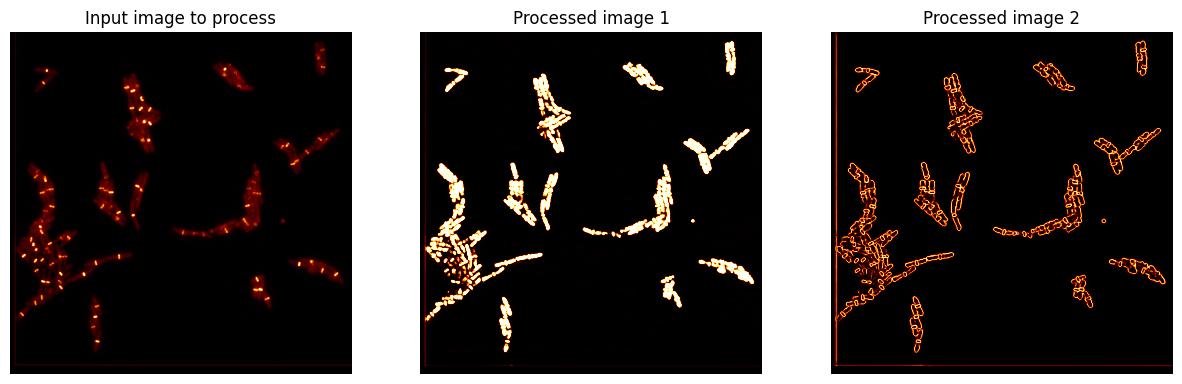

In [ ]:
#@markdown ##Indicate the path to the image

# You might want to use the test images (like on section 4.1.)
use_test_image = False #@param {type:"boolean"}

#@markdown ### If you have an image in a folder to segment, copy the path to it here:
path2image = "/home/ocb/Documents/IH/DeepBacs/Multilabel_U-Net_dataset_B.subtilis/test/source/test_9.tif"  #@param {type:"string"}
#@markdown ### Indicate where to save the output of the model:
save_outputs = "/home/ocb/Desktop"  #@param {type:"string"}

if use_test_image:
  # Download and take the input paths from the model description
  input_paths = {ipt.id: download(ipt.test_tensor).path for ipt in model.inputs}
else:
  # Load the paths to the input images
  input_paths = {"input0": Path(path2image)}

# The prediction pipeline expects a Sample object from bioimageio.core
input_sample = create_sample_for_model(
    model=model, inputs=input_paths, sample_id="my_demo_sample"
)

# The prediction pipeline expects a Sample object from bioimageio.core
prediction = predict(model=model, inputs=input_sample)

# Convert both input and output sample tensors into a NumPy format to save and plot them
input_sample_tensor = input_sample.members["input0"].data
input_sample_tensor = np.squeeze(input_sample_tensor)
prediction_tensor = prediction.members["output0"].data
prediction_tensor = np.squeeze(prediction_tensor)

# Save the output results
filename = path2image.split(os.sep)[-1]
name, extenstion = filename.split('.')
for i, f in enumerate(prediction_tensor):
  imsave(uri=os.path.join(save_outputs, f"{name}_{i}.{extenstion}"), im=f)

# Plot the input image and the predicted results
plt.figure(figsize=(15,15))
plt.subplot(1,1+prediction_tensor.shape[0],1)
plt.imshow(np.squeeze(input_sample_tensor), cmap="afmhot")
plt.axis('off')
plt.title("Input image to process")

for pred_idx, pred in enumerate(prediction_tensor):
    plt.subplot(1,1+prediction_tensor.shape[0],pred_idx+2)
    plt.imshow(pred, cmap="afmhot")
    plt.axis('off')
    plt.title(f"Processed image {pred_idx+1}")
plt.show()



##### Run the following cell to set up the parameters for the fine-tuning and start it.

Model UNet2d succesfully initialized!
['cuda']
[INFO] found 80 examples in the training set...
[INFO] found 10 examples in the test set...
Results of the prediction before finetuning
---------------------------------------------


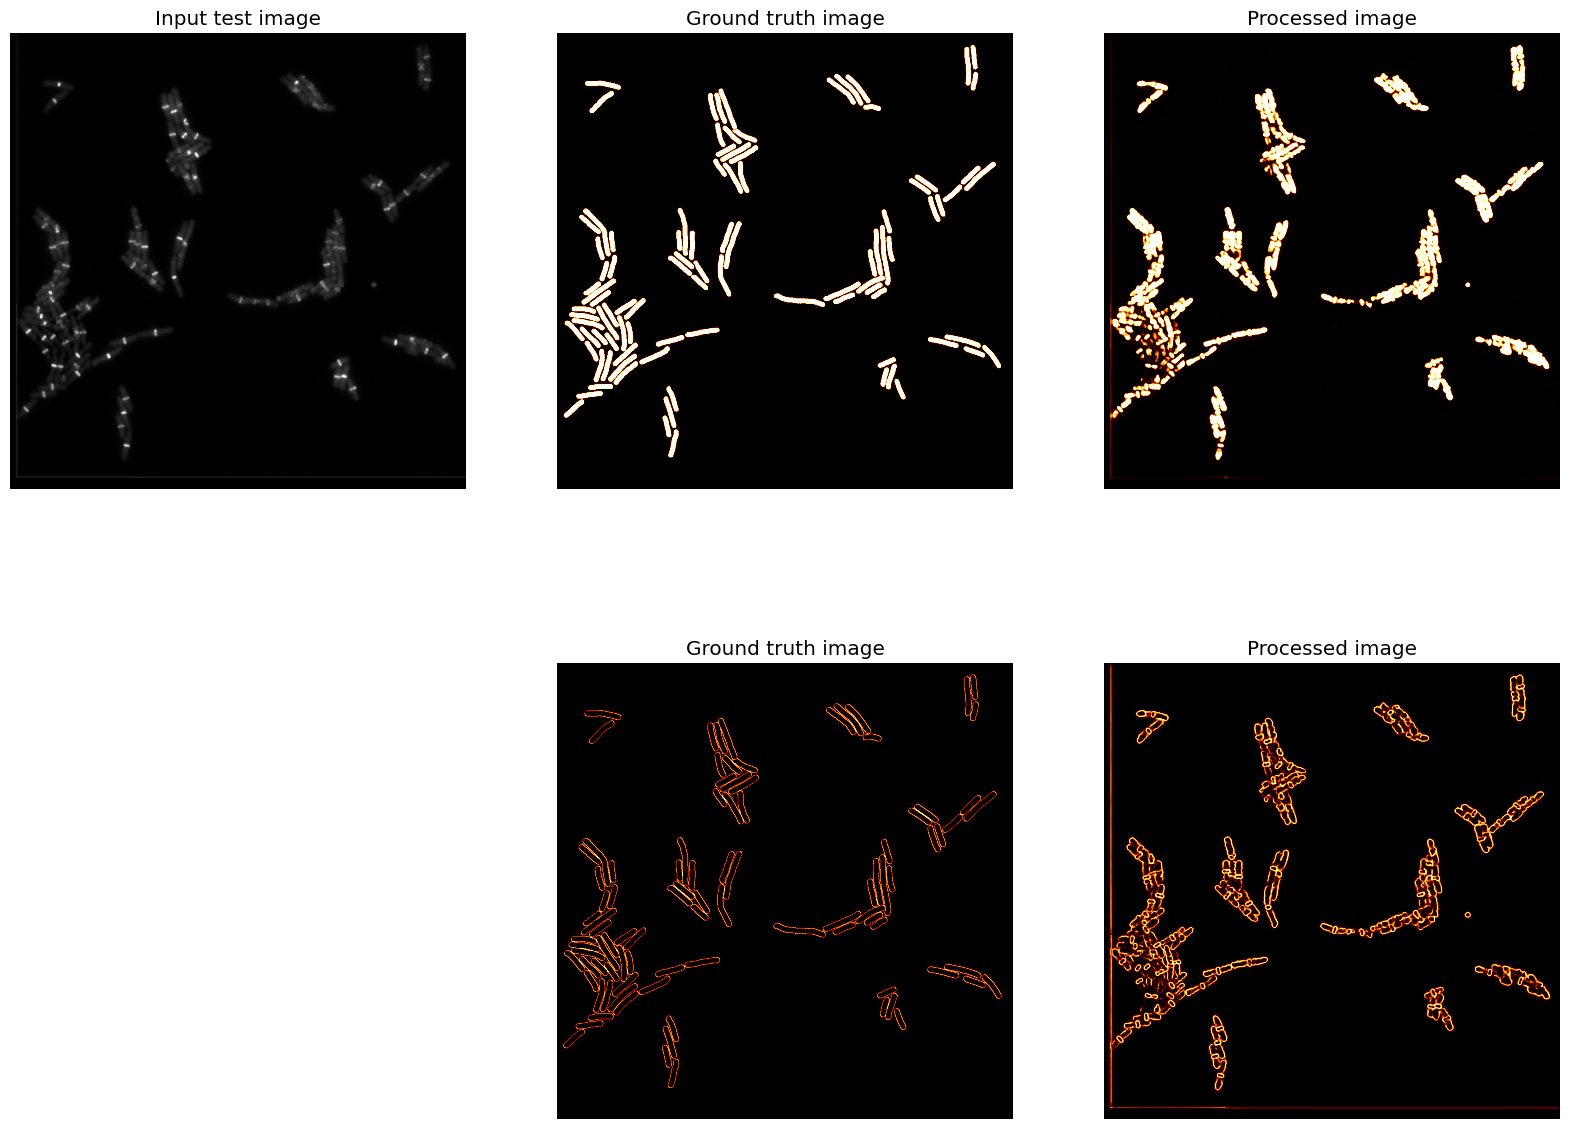

---------------------------------------------
[INFO] training the network...


  0%|          | 1/200 [00:02<09:08,  2.76s/it]

[INFO] EPOCH: 1/200
Train loss: 0.025662, Test loss: 0.0278


  1%|          | 2/200 [00:05<09:07,  2.76s/it]

[INFO] EPOCH: 2/200
Train loss: 0.022944, Test loss: 0.0276


  2%|▏         | 3/200 [00:08<09:03,  2.76s/it]

[INFO] EPOCH: 3/200
Train loss: 0.024584, Test loss: 0.0275


  2%|▏         | 4/200 [00:11<09:01,  2.76s/it]

[INFO] EPOCH: 4/200
Train loss: 0.024990, Test loss: 0.0274


  2%|▎         | 5/200 [00:13<09:00,  2.77s/it]

[INFO] EPOCH: 5/200
Train loss: 0.024861, Test loss: 0.0272


  3%|▎         | 6/200 [00:16<09:00,  2.79s/it]

[INFO] EPOCH: 6/200
Train loss: 0.025330, Test loss: 0.0271


  4%|▎         | 7/200 [00:19<09:00,  2.80s/it]

[INFO] EPOCH: 7/200
Train loss: 0.025594, Test loss: 0.0271


  4%|▍         | 8/200 [00:22<08:56,  2.79s/it]

[INFO] EPOCH: 8/200
Train loss: 0.025088, Test loss: 0.0270


  4%|▍         | 9/200 [00:25<08:51,  2.78s/it]

[INFO] EPOCH: 9/200
Train loss: 0.025325, Test loss: 0.0270


  5%|▌         | 10/200 [00:27<08:50,  2.79s/it]

[INFO] EPOCH: 10/200
Train loss: 0.022445, Test loss: 0.0269


  6%|▌         | 11/200 [00:30<08:47,  2.79s/it]

[INFO] EPOCH: 11/200
Train loss: 0.025929, Test loss: 0.0269


  6%|▌         | 12/200 [00:33<08:45,  2.79s/it]

[INFO] EPOCH: 12/200
Train loss: 0.026725, Test loss: 0.0269


  6%|▋         | 13/200 [00:36<08:42,  2.79s/it]

[INFO] EPOCH: 13/200
Train loss: 0.023557, Test loss: 0.0269


  7%|▋         | 14/200 [00:38<08:38,  2.79s/it]

[INFO] EPOCH: 14/200
Train loss: 0.023057, Test loss: 0.0269


  8%|▊         | 15/200 [00:41<08:36,  2.79s/it]

[INFO] EPOCH: 15/200
Train loss: 0.023498, Test loss: 0.0269


  8%|▊         | 16/200 [00:44<08:34,  2.80s/it]

[INFO] EPOCH: 16/200
Train loss: 0.021065, Test loss: 0.0269


  8%|▊         | 17/200 [00:47<08:31,  2.80s/it]

[INFO] EPOCH: 17/200
Train loss: 0.021672, Test loss: 0.0269


  9%|▉         | 18/200 [00:50<08:28,  2.79s/it]

[INFO] EPOCH: 18/200
Train loss: 0.021956, Test loss: 0.0269


 10%|▉         | 19/200 [00:52<08:27,  2.80s/it]

[INFO] EPOCH: 19/200
Train loss: 0.028667, Test loss: 0.0269


 10%|█         | 20/200 [00:55<08:25,  2.81s/it]

[INFO] EPOCH: 20/200
Train loss: 0.025375, Test loss: 0.0269


 10%|█         | 21/200 [00:58<08:23,  2.81s/it]

[INFO] EPOCH: 21/200
Train loss: 0.024979, Test loss: 0.0269


 11%|█         | 22/200 [01:01<08:19,  2.81s/it]

[INFO] EPOCH: 22/200
Train loss: 0.022138, Test loss: 0.0269


 12%|█▏        | 23/200 [01:04<08:15,  2.80s/it]

[INFO] EPOCH: 23/200
Train loss: 0.023314, Test loss: 0.0269


 12%|█▏        | 24/200 [01:07<08:13,  2.80s/it]

[INFO] EPOCH: 24/200
Train loss: 0.022363, Test loss: 0.0269


 12%|█▎        | 25/200 [01:09<08:09,  2.79s/it]

[INFO] EPOCH: 25/200
Train loss: 0.025125, Test loss: 0.0268


 13%|█▎        | 26/200 [01:12<08:06,  2.80s/it]

[INFO] EPOCH: 26/200
Train loss: 0.026579, Test loss: 0.0268


 14%|█▎        | 27/200 [01:15<08:05,  2.81s/it]

[INFO] EPOCH: 27/200
Train loss: 0.023327, Test loss: 0.0268


 14%|█▍        | 28/200 [01:18<08:03,  2.81s/it]

[INFO] EPOCH: 28/200
Train loss: 0.021935, Test loss: 0.0267


 14%|█▍        | 29/200 [01:21<08:01,  2.82s/it]

[INFO] EPOCH: 29/200
Train loss: 0.029279, Test loss: 0.0267


 15%|█▌        | 30/200 [01:23<08:00,  2.83s/it]

[INFO] EPOCH: 30/200
Train loss: 0.022949, Test loss: 0.0267


 16%|█▌        | 31/200 [01:26<07:56,  2.82s/it]

[INFO] EPOCH: 31/200
Train loss: 0.024114, Test loss: 0.0267


 16%|█▌        | 32/200 [01:29<07:51,  2.81s/it]

[INFO] EPOCH: 32/200
Train loss: 0.019831, Test loss: 0.0267


 16%|█▋        | 33/200 [01:32<07:51,  2.82s/it]

[INFO] EPOCH: 33/200
Train loss: 0.020854, Test loss: 0.0267


 17%|█▋        | 34/200 [01:35<07:47,  2.82s/it]

[INFO] EPOCH: 34/200
Train loss: 0.024492, Test loss: 0.0267


 18%|█▊        | 35/200 [01:37<07:43,  2.81s/it]

[INFO] EPOCH: 35/200
Train loss: 0.024624, Test loss: 0.0267


 18%|█▊        | 36/200 [01:40<07:40,  2.81s/it]

[INFO] EPOCH: 36/200
Train loss: 0.023512, Test loss: 0.0267


 18%|█▊        | 37/200 [01:43<07:34,  2.79s/it]

[INFO] EPOCH: 37/200
Train loss: 0.024093, Test loss: 0.0267


 19%|█▉        | 38/200 [01:46<07:29,  2.78s/it]

[INFO] EPOCH: 38/200
Train loss: 0.021731, Test loss: 0.0267


 20%|█▉        | 39/200 [01:49<07:30,  2.80s/it]

[INFO] EPOCH: 39/200
Train loss: 0.027034, Test loss: 0.0267


 20%|██        | 40/200 [01:51<07:27,  2.80s/it]

[INFO] EPOCH: 40/200
Train loss: 0.025087, Test loss: 0.0266


 20%|██        | 41/200 [01:54<07:29,  2.82s/it]

[INFO] EPOCH: 41/200
Train loss: 0.023898, Test loss: 0.0266


 21%|██        | 42/200 [01:57<07:26,  2.83s/it]

[INFO] EPOCH: 42/200
Train loss: 0.027988, Test loss: 0.0266


 22%|██▏       | 43/200 [02:00<07:25,  2.84s/it]

[INFO] EPOCH: 43/200
Train loss: 0.021301, Test loss: 0.0266


 22%|██▏       | 44/200 [02:03<07:24,  2.85s/it]

[INFO] EPOCH: 44/200
Train loss: 0.026453, Test loss: 0.0266


 22%|██▎       | 45/200 [02:06<07:21,  2.85s/it]

[INFO] EPOCH: 45/200
Train loss: 0.021756, Test loss: 0.0266


 23%|██▎       | 46/200 [02:09<07:19,  2.86s/it]

[INFO] EPOCH: 46/200
Train loss: 0.022854, Test loss: 0.0266


 24%|██▎       | 47/200 [02:11<07:13,  2.83s/it]

[INFO] EPOCH: 47/200
Train loss: 0.023064, Test loss: 0.0266


 24%|██▍       | 48/200 [02:14<07:10,  2.83s/it]

[INFO] EPOCH: 48/200
Train loss: 0.023110, Test loss: 0.0266


 24%|██▍       | 49/200 [02:17<07:09,  2.84s/it]

[INFO] EPOCH: 49/200
Train loss: 0.023546, Test loss: 0.0266


 25%|██▌       | 50/200 [02:20<07:07,  2.85s/it]

[INFO] EPOCH: 50/200
Train loss: 0.023111, Test loss: 0.0266


 26%|██▌       | 51/200 [02:23<07:07,  2.87s/it]

[INFO] EPOCH: 51/200
Train loss: 0.025729, Test loss: 0.0266


 26%|██▌       | 52/200 [02:26<07:05,  2.88s/it]

[INFO] EPOCH: 52/200
Train loss: 0.025870, Test loss: 0.0266


 26%|██▋       | 53/200 [02:29<07:01,  2.86s/it]

[INFO] EPOCH: 53/200
Train loss: 0.021416, Test loss: 0.0266


 27%|██▋       | 54/200 [02:31<06:57,  2.86s/it]

[INFO] EPOCH: 54/200
Train loss: 0.027013, Test loss: 0.0266


 28%|██▊       | 55/200 [02:34<06:57,  2.88s/it]

[INFO] EPOCH: 55/200
Train loss: 0.021862, Test loss: 0.0266


 28%|██▊       | 56/200 [02:37<06:55,  2.89s/it]

[INFO] EPOCH: 56/200
Train loss: 0.022601, Test loss: 0.0266


 28%|██▊       | 57/200 [02:40<06:55,  2.91s/it]

[INFO] EPOCH: 57/200
Train loss: 0.023247, Test loss: 0.0266


 29%|██▉       | 58/200 [02:43<06:54,  2.92s/it]

[INFO] EPOCH: 58/200
Train loss: 0.024047, Test loss: 0.0266


 30%|██▉       | 59/200 [02:46<06:50,  2.91s/it]

[INFO] EPOCH: 59/200
Train loss: 0.019484, Test loss: 0.0266


 30%|███       | 60/200 [02:49<06:49,  2.93s/it]

[INFO] EPOCH: 60/200
Train loss: 0.024476, Test loss: 0.0266


 30%|███       | 61/200 [02:52<06:42,  2.90s/it]

[INFO] EPOCH: 61/200
Train loss: 0.023968, Test loss: 0.0266


 31%|███       | 62/200 [02:55<06:40,  2.90s/it]

[INFO] EPOCH: 62/200
Train loss: 0.019266, Test loss: 0.0266


 32%|███▏      | 63/200 [02:58<06:34,  2.88s/it]

[INFO] EPOCH: 63/200
Train loss: 0.027379, Test loss: 0.0265


 32%|███▏      | 64/200 [03:00<06:27,  2.85s/it]

[INFO] EPOCH: 64/200
Train loss: 0.027368, Test loss: 0.0265


 32%|███▎      | 65/200 [03:03<06:24,  2.85s/it]

[INFO] EPOCH: 65/200
Train loss: 0.022189, Test loss: 0.0265


 33%|███▎      | 66/200 [03:06<06:21,  2.84s/it]

[INFO] EPOCH: 66/200
Train loss: 0.023189, Test loss: 0.0265


 34%|███▎      | 67/200 [03:09<06:18,  2.85s/it]

[INFO] EPOCH: 67/200
Train loss: 0.022813, Test loss: 0.0265


 34%|███▍      | 68/200 [03:12<06:15,  2.84s/it]

[INFO] EPOCH: 68/200
Train loss: 0.022899, Test loss: 0.0266


 34%|███▍      | 69/200 [03:15<06:13,  2.85s/it]

[INFO] EPOCH: 69/200
Train loss: 0.021402, Test loss: 0.0266


 35%|███▌      | 70/200 [03:17<06:12,  2.86s/it]

[INFO] EPOCH: 70/200
Train loss: 0.022355, Test loss: 0.0266


 36%|███▌      | 71/200 [03:20<06:12,  2.89s/it]

[INFO] EPOCH: 71/200
Train loss: 0.024267, Test loss: 0.0266


 36%|███▌      | 72/200 [03:23<06:10,  2.90s/it]

[INFO] EPOCH: 72/200
Train loss: 0.025082, Test loss: 0.0266


 36%|███▋      | 73/200 [03:26<06:07,  2.89s/it]

[INFO] EPOCH: 73/200
Train loss: 0.029279, Test loss: 0.0266


 37%|███▋      | 74/200 [03:29<06:02,  2.87s/it]

[INFO] EPOCH: 74/200
Train loss: 0.024559, Test loss: 0.0265


 38%|███▊      | 75/200 [03:32<05:59,  2.87s/it]

[INFO] EPOCH: 75/200
Train loss: 0.022325, Test loss: 0.0265


 38%|███▊      | 76/200 [03:35<05:58,  2.89s/it]

[INFO] EPOCH: 76/200
Train loss: 0.025569, Test loss: 0.0265


 38%|███▊      | 77/200 [03:38<05:57,  2.91s/it]

[INFO] EPOCH: 77/200
Train loss: 0.017711, Test loss: 0.0265


 39%|███▉      | 78/200 [03:41<05:51,  2.88s/it]

[INFO] EPOCH: 78/200
Train loss: 0.023931, Test loss: 0.0265


 40%|███▉      | 79/200 [03:44<05:49,  2.89s/it]

[INFO] EPOCH: 79/200
Train loss: 0.023837, Test loss: 0.0265


 40%|████      | 80/200 [03:46<05:46,  2.89s/it]

[INFO] EPOCH: 80/200
Train loss: 0.027127, Test loss: 0.0264


 40%|████      | 81/200 [03:49<05:42,  2.88s/it]

[INFO] EPOCH: 81/200
Train loss: 0.024373, Test loss: 0.0264


 41%|████      | 82/200 [03:52<05:38,  2.87s/it]

[INFO] EPOCH: 82/200
Train loss: 0.020738, Test loss: 0.0264


 42%|████▏     | 83/200 [03:55<05:34,  2.86s/it]

[INFO] EPOCH: 83/200
Train loss: 0.022161, Test loss: 0.0264


 42%|████▏     | 84/200 [03:58<05:31,  2.86s/it]

[INFO] EPOCH: 84/200
Train loss: 0.021327, Test loss: 0.0264


 42%|████▎     | 85/200 [04:01<05:30,  2.87s/it]

[INFO] EPOCH: 85/200
Train loss: 0.022969, Test loss: 0.0264


 43%|████▎     | 86/200 [04:04<05:28,  2.88s/it]

[INFO] EPOCH: 86/200
Train loss: 0.024615, Test loss: 0.0265


 44%|████▎     | 87/200 [04:07<05:26,  2.89s/it]

[INFO] EPOCH: 87/200
Train loss: 0.024799, Test loss: 0.0265


 44%|████▍     | 88/200 [04:09<05:25,  2.91s/it]

[INFO] EPOCH: 88/200
Train loss: 0.025091, Test loss: 0.0265


 44%|████▍     | 89/200 [04:12<05:22,  2.91s/it]

[INFO] EPOCH: 89/200
Train loss: 0.023134, Test loss: 0.0265


 45%|████▌     | 90/200 [04:15<05:20,  2.91s/it]

[INFO] EPOCH: 90/200
Train loss: 0.021714, Test loss: 0.0265


 46%|████▌     | 91/200 [04:18<05:18,  2.92s/it]

[INFO] EPOCH: 91/200
Train loss: 0.024873, Test loss: 0.0265


 46%|████▌     | 92/200 [04:21<05:15,  2.92s/it]

[INFO] EPOCH: 92/200
Train loss: 0.021781, Test loss: 0.0264


 46%|████▋     | 93/200 [04:24<05:14,  2.94s/it]

[INFO] EPOCH: 93/200
Train loss: 0.023868, Test loss: 0.0264


 47%|████▋     | 94/200 [04:27<05:11,  2.94s/it]

[INFO] EPOCH: 94/200
Train loss: 0.024080, Test loss: 0.0264


 48%|████▊     | 95/200 [04:30<05:06,  2.92s/it]

[INFO] EPOCH: 95/200
Train loss: 0.022704, Test loss: 0.0264


 48%|████▊     | 96/200 [04:33<05:03,  2.92s/it]

[INFO] EPOCH: 96/200
Train loss: 0.022313, Test loss: 0.0264


 48%|████▊     | 97/200 [04:36<05:00,  2.92s/it]

[INFO] EPOCH: 97/200
Train loss: 0.021332, Test loss: 0.0264


 49%|████▉     | 98/200 [04:39<04:58,  2.93s/it]

[INFO] EPOCH: 98/200
Train loss: 0.023466, Test loss: 0.0263


 50%|████▉     | 99/200 [04:42<04:56,  2.94s/it]

[INFO] EPOCH: 99/200
Train loss: 0.024794, Test loss: 0.0263


 50%|█████     | 100/200 [04:45<04:54,  2.94s/it]

[INFO] EPOCH: 100/200
Train loss: 0.024155, Test loss: 0.0263


 50%|█████     | 101/200 [04:48<04:50,  2.94s/it]

[INFO] EPOCH: 101/200
Train loss: 0.020066, Test loss: 0.0263


 51%|█████     | 102/200 [04:51<04:48,  2.94s/it]

[INFO] EPOCH: 102/200
Train loss: 0.022585, Test loss: 0.0263


 52%|█████▏    | 103/200 [04:53<04:45,  2.94s/it]

[INFO] EPOCH: 103/200
Train loss: 0.024549, Test loss: 0.0263


 52%|█████▏    | 104/200 [04:56<04:42,  2.94s/it]

[INFO] EPOCH: 104/200
Train loss: 0.023478, Test loss: 0.0263


 52%|█████▎    | 105/200 [04:59<04:39,  2.94s/it]

[INFO] EPOCH: 105/200
Train loss: 0.023192, Test loss: 0.0263


 53%|█████▎    | 106/200 [05:02<04:37,  2.95s/it]

[INFO] EPOCH: 106/200
Train loss: 0.023658, Test loss: 0.0263


 54%|█████▎    | 107/200 [05:05<04:33,  2.94s/it]

[INFO] EPOCH: 107/200
Train loss: 0.024494, Test loss: 0.0263


 54%|█████▍    | 108/200 [05:08<04:29,  2.93s/it]

[INFO] EPOCH: 108/200
Train loss: 0.024570, Test loss: 0.0263


 55%|█████▍    | 109/200 [05:11<04:26,  2.93s/it]

[INFO] EPOCH: 109/200
Train loss: 0.024680, Test loss: 0.0263


 55%|█████▌    | 110/200 [05:14<04:23,  2.93s/it]

[INFO] EPOCH: 110/200
Train loss: 0.023684, Test loss: 0.0263


 56%|█████▌    | 111/200 [05:17<04:21,  2.94s/it]

[INFO] EPOCH: 111/200
Train loss: 0.024144, Test loss: 0.0263


 56%|█████▌    | 112/200 [05:20<04:19,  2.94s/it]

[INFO] EPOCH: 112/200
Train loss: 0.020713, Test loss: 0.0263


 56%|█████▋    | 113/200 [05:23<04:16,  2.95s/it]

[INFO] EPOCH: 113/200
Train loss: 0.023023, Test loss: 0.0263


 57%|█████▋    | 114/200 [05:26<04:13,  2.95s/it]

[INFO] EPOCH: 114/200
Train loss: 0.024363, Test loss: 0.0263


 57%|█████▊    | 115/200 [05:29<04:09,  2.94s/it]

[INFO] EPOCH: 115/200
Train loss: 0.023917, Test loss: 0.0263


 58%|█████▊    | 116/200 [05:32<04:06,  2.93s/it]

[INFO] EPOCH: 116/200
Train loss: 0.021592, Test loss: 0.0263


 58%|█████▊    | 117/200 [05:35<04:03,  2.93s/it]

[INFO] EPOCH: 117/200
Train loss: 0.024258, Test loss: 0.0263


 59%|█████▉    | 118/200 [05:38<04:00,  2.93s/it]

[INFO] EPOCH: 118/200
Train loss: 0.023800, Test loss: 0.0263


 60%|█████▉    | 119/200 [05:40<03:57,  2.93s/it]

[INFO] EPOCH: 119/200
Train loss: 0.024666, Test loss: 0.0263


 60%|██████    | 120/200 [05:43<03:54,  2.94s/it]

[INFO] EPOCH: 120/200
Train loss: 0.021494, Test loss: 0.0263


 60%|██████    | 121/200 [05:46<03:54,  2.97s/it]

[INFO] EPOCH: 121/200
Train loss: 0.026020, Test loss: 0.0263


 61%|██████    | 122/200 [05:49<03:50,  2.95s/it]

[INFO] EPOCH: 122/200
Train loss: 0.019915, Test loss: 0.0263


 62%|██████▏   | 123/200 [05:52<03:46,  2.94s/it]

[INFO] EPOCH: 123/200
Train loss: 0.021926, Test loss: 0.0263


 62%|██████▏   | 124/200 [05:55<03:43,  2.94s/it]

[INFO] EPOCH: 124/200
Train loss: 0.021273, Test loss: 0.0263


 62%|██████▎   | 125/200 [05:58<03:40,  2.93s/it]

[INFO] EPOCH: 125/200
Train loss: 0.019483, Test loss: 0.0263


 63%|██████▎   | 126/200 [06:01<03:37,  2.93s/it]

[INFO] EPOCH: 126/200
Train loss: 0.024483, Test loss: 0.0263


 64%|██████▎   | 127/200 [06:04<03:34,  2.94s/it]

[INFO] EPOCH: 127/200
Train loss: 0.021935, Test loss: 0.0263


 64%|██████▍   | 128/200 [06:07<03:32,  2.95s/it]

[INFO] EPOCH: 128/200
Train loss: 0.023127, Test loss: 0.0263


 64%|██████▍   | 129/200 [06:10<03:28,  2.94s/it]

[INFO] EPOCH: 129/200
Train loss: 0.019960, Test loss: 0.0262


 65%|██████▌   | 130/200 [06:13<03:25,  2.94s/it]

[INFO] EPOCH: 130/200
Train loss: 0.021399, Test loss: 0.0262


 66%|██████▌   | 131/200 [06:16<03:23,  2.95s/it]

[INFO] EPOCH: 131/200
Train loss: 0.027349, Test loss: 0.0262


 66%|██████▌   | 132/200 [06:19<03:20,  2.95s/it]

[INFO] EPOCH: 132/200
Train loss: 0.022372, Test loss: 0.0262


 66%|██████▋   | 133/200 [06:22<03:17,  2.95s/it]

[INFO] EPOCH: 133/200
Train loss: 0.025232, Test loss: 0.0262


 67%|██████▋   | 134/200 [06:25<03:13,  2.94s/it]

[INFO] EPOCH: 134/200
Train loss: 0.021770, Test loss: 0.0262


 68%|██████▊   | 135/200 [06:28<03:10,  2.93s/it]

[INFO] EPOCH: 135/200
Train loss: 0.020590, Test loss: 0.0262


 68%|██████▊   | 136/200 [06:31<03:07,  2.93s/it]

[INFO] EPOCH: 136/200
Train loss: 0.023575, Test loss: 0.0262


 68%|██████▊   | 137/200 [06:33<03:04,  2.93s/it]

[INFO] EPOCH: 137/200
Train loss: 0.023632, Test loss: 0.0262


 69%|██████▉   | 138/200 [06:36<03:02,  2.94s/it]

[INFO] EPOCH: 138/200
Train loss: 0.019375, Test loss: 0.0262


 70%|██████▉   | 139/200 [06:39<02:58,  2.93s/it]

[INFO] EPOCH: 139/200
Train loss: 0.024534, Test loss: 0.0263


 70%|███████   | 140/200 [06:42<02:56,  2.94s/it]

[INFO] EPOCH: 140/200
Train loss: 0.026143, Test loss: 0.0263


 70%|███████   | 141/200 [06:45<02:53,  2.94s/it]

[INFO] EPOCH: 141/200
Train loss: 0.024574, Test loss: 0.0263


 71%|███████   | 142/200 [06:48<02:50,  2.94s/it]

[INFO] EPOCH: 142/200
Train loss: 0.024824, Test loss: 0.0263


 72%|███████▏  | 143/200 [06:51<02:47,  2.93s/it]

[INFO] EPOCH: 143/200
Train loss: 0.020508, Test loss: 0.0262


 72%|███████▏  | 144/200 [06:54<02:44,  2.93s/it]

[INFO] EPOCH: 144/200
Train loss: 0.021010, Test loss: 0.0262


 72%|███████▎  | 145/200 [06:57<02:40,  2.93s/it]

[INFO] EPOCH: 145/200
Train loss: 0.021603, Test loss: 0.0262


 73%|███████▎  | 146/200 [07:00<02:37,  2.92s/it]

[INFO] EPOCH: 146/200
Train loss: 0.020640, Test loss: 0.0262


 74%|███████▎  | 147/200 [07:03<02:34,  2.92s/it]

[INFO] EPOCH: 147/200
Train loss: 0.021881, Test loss: 0.0262


 74%|███████▍  | 148/200 [07:06<02:32,  2.92s/it]

[INFO] EPOCH: 148/200
Train loss: 0.024612, Test loss: 0.0262


 74%|███████▍  | 149/200 [07:09<02:29,  2.93s/it]

[INFO] EPOCH: 149/200
Train loss: 0.022459, Test loss: 0.0262


 75%|███████▌  | 150/200 [07:12<02:27,  2.95s/it]

[INFO] EPOCH: 150/200
Train loss: 0.020852, Test loss: 0.0262


 76%|███████▌  | 151/200 [07:15<02:25,  2.97s/it]

[INFO] EPOCH: 151/200
Train loss: 0.025967, Test loss: 0.0262


 76%|███████▌  | 152/200 [07:18<02:21,  2.96s/it]

[INFO] EPOCH: 152/200
Train loss: 0.021450, Test loss: 0.0262


 76%|███████▋  | 153/200 [07:20<02:18,  2.94s/it]

[INFO] EPOCH: 153/200
Train loss: 0.024775, Test loss: 0.0262


 77%|███████▋  | 154/200 [07:23<02:15,  2.94s/it]

[INFO] EPOCH: 154/200
Train loss: 0.024065, Test loss: 0.0262


 78%|███████▊  | 155/200 [07:26<02:12,  2.94s/it]

[INFO] EPOCH: 155/200
Train loss: 0.022598, Test loss: 0.0262


 78%|███████▊  | 156/200 [07:29<02:08,  2.93s/it]

[INFO] EPOCH: 156/200
Train loss: 0.024658, Test loss: 0.0262


 78%|███████▊  | 157/200 [07:32<02:06,  2.94s/it]

[INFO] EPOCH: 157/200
Train loss: 0.023925, Test loss: 0.0262


 79%|███████▉  | 158/200 [07:35<02:03,  2.93s/it]

[INFO] EPOCH: 158/200
Train loss: 0.024729, Test loss: 0.0262


 80%|███████▉  | 159/200 [07:38<01:59,  2.92s/it]

[INFO] EPOCH: 159/200
Train loss: 0.027675, Test loss: 0.0262


 80%|████████  | 160/200 [07:41<01:57,  2.93s/it]

[INFO] EPOCH: 160/200
Train loss: 0.024617, Test loss: 0.0262


 80%|████████  | 161/200 [07:44<01:53,  2.91s/it]

[INFO] EPOCH: 161/200
Train loss: 0.022350, Test loss: 0.0261


 81%|████████  | 162/200 [07:47<01:51,  2.92s/it]

[INFO] EPOCH: 162/200
Train loss: 0.026009, Test loss: 0.0261


 82%|████████▏ | 163/200 [07:50<01:48,  2.92s/it]

[INFO] EPOCH: 163/200
Train loss: 0.019927, Test loss: 0.0261


 82%|████████▏ | 164/200 [07:53<01:45,  2.93s/it]

[INFO] EPOCH: 164/200
Train loss: 0.023437, Test loss: 0.0261


 82%|████████▎ | 165/200 [07:56<01:42,  2.94s/it]

[INFO] EPOCH: 165/200
Train loss: 0.023524, Test loss: 0.0261


 83%|████████▎ | 166/200 [07:59<01:40,  2.95s/it]

[INFO] EPOCH: 166/200
Train loss: 0.023112, Test loss: 0.0261


 84%|████████▎ | 167/200 [08:02<01:37,  2.95s/it]

[INFO] EPOCH: 167/200
Train loss: 0.021841, Test loss: 0.0261


 84%|████████▍ | 168/200 [08:04<01:34,  2.94s/it]

[INFO] EPOCH: 168/200
Train loss: 0.022984, Test loss: 0.0261


 84%|████████▍ | 169/200 [08:07<01:31,  2.95s/it]

[INFO] EPOCH: 169/200
Train loss: 0.022185, Test loss: 0.0261


 85%|████████▌ | 170/200 [08:10<01:28,  2.95s/it]

[INFO] EPOCH: 170/200
Train loss: 0.022788, Test loss: 0.0261


 86%|████████▌ | 171/200 [08:13<01:25,  2.95s/it]

[INFO] EPOCH: 171/200
Train loss: 0.024695, Test loss: 0.0261


 86%|████████▌ | 172/200 [08:16<01:22,  2.95s/it]

[INFO] EPOCH: 172/200
Train loss: 0.021071, Test loss: 0.0261


 86%|████████▋ | 173/200 [08:19<01:19,  2.95s/it]

[INFO] EPOCH: 173/200
Train loss: 0.019949, Test loss: 0.0261


 87%|████████▋ | 174/200 [08:22<01:16,  2.96s/it]

[INFO] EPOCH: 174/200
Train loss: 0.022551, Test loss: 0.0262


 88%|████████▊ | 175/200 [08:25<01:13,  2.94s/it]

[INFO] EPOCH: 175/200
Train loss: 0.026615, Test loss: 0.0262


 88%|████████▊ | 176/200 [08:28<01:10,  2.94s/it]

[INFO] EPOCH: 176/200
Train loss: 0.022989, Test loss: 0.0262


 88%|████████▊ | 177/200 [08:31<01:07,  2.94s/it]

[INFO] EPOCH: 177/200
Train loss: 0.024996, Test loss: 0.0261


 89%|████████▉ | 178/200 [08:34<01:04,  2.95s/it]

[INFO] EPOCH: 178/200
Train loss: 0.022841, Test loss: 0.0261


 90%|████████▉ | 179/200 [08:37<01:01,  2.94s/it]

[INFO] EPOCH: 179/200
Train loss: 0.022586, Test loss: 0.0261


 90%|█████████ | 180/200 [08:40<00:58,  2.94s/it]

[INFO] EPOCH: 180/200
Train loss: 0.023630, Test loss: 0.0261


 90%|█████████ | 181/200 [08:43<00:55,  2.94s/it]

[INFO] EPOCH: 181/200
Train loss: 0.021566, Test loss: 0.0261


 91%|█████████ | 182/200 [08:46<00:52,  2.94s/it]

[INFO] EPOCH: 182/200
Train loss: 0.022511, Test loss: 0.0261


 92%|█████████▏| 183/200 [08:49<00:49,  2.93s/it]

[INFO] EPOCH: 183/200
Train loss: 0.024417, Test loss: 0.0261


 92%|█████████▏| 184/200 [08:51<00:46,  2.93s/it]

[INFO] EPOCH: 184/200
Train loss: 0.023248, Test loss: 0.0261


 92%|█████████▎| 185/200 [08:54<00:43,  2.93s/it]

[INFO] EPOCH: 185/200
Train loss: 0.023426, Test loss: 0.0260


 93%|█████████▎| 186/200 [08:57<00:41,  2.94s/it]

[INFO] EPOCH: 186/200
Train loss: 0.028922, Test loss: 0.0260


 94%|█████████▎| 187/200 [09:00<00:38,  2.94s/it]

[INFO] EPOCH: 187/200
Train loss: 0.025609, Test loss: 0.0260


 94%|█████████▍| 188/200 [09:03<00:35,  2.93s/it]

[INFO] EPOCH: 188/200
Train loss: 0.020626, Test loss: 0.0260


 94%|█████████▍| 189/200 [09:06<00:32,  2.92s/it]

[INFO] EPOCH: 189/200
Train loss: 0.021660, Test loss: 0.0260


 95%|█████████▌| 190/200 [09:09<00:29,  2.92s/it]

[INFO] EPOCH: 190/200
Train loss: 0.025327, Test loss: 0.0261


 96%|█████████▌| 191/200 [09:12<00:26,  2.92s/it]

[INFO] EPOCH: 191/200
Train loss: 0.020960, Test loss: 0.0261


 96%|█████████▌| 192/200 [09:15<00:23,  2.93s/it]

[INFO] EPOCH: 192/200
Train loss: 0.022061, Test loss: 0.0261


 96%|█████████▋| 193/200 [09:18<00:20,  2.93s/it]

[INFO] EPOCH: 193/200
Train loss: 0.022703, Test loss: 0.0261


 97%|█████████▋| 194/200 [09:21<00:17,  2.94s/it]

[INFO] EPOCH: 194/200
Train loss: 0.025716, Test loss: 0.0261


 98%|█████████▊| 195/200 [09:24<00:14,  2.92s/it]

[INFO] EPOCH: 195/200
Train loss: 0.022246, Test loss: 0.0261


 98%|█████████▊| 196/200 [09:27<00:11,  2.92s/it]

[INFO] EPOCH: 196/200
Train loss: 0.021477, Test loss: 0.0261


 98%|█████████▊| 197/200 [09:30<00:08,  2.92s/it]

[INFO] EPOCH: 197/200
Train loss: 0.026158, Test loss: 0.0261


 99%|█████████▉| 198/200 [09:32<00:05,  2.91s/it]

[INFO] EPOCH: 198/200
Train loss: 0.022703, Test loss: 0.0261


100%|█████████▉| 199/200 [09:35<00:02,  2.92s/it]

[INFO] EPOCH: 199/200
Train loss: 0.027487, Test loss: 0.0260


100%|██████████| 200/200 [09:38<00:00,  2.89s/it]

[INFO] EPOCH: 200/200
Train loss: 0.022327, Test loss: 0.0260
[INFO] total time taken to train the model: 578.82s


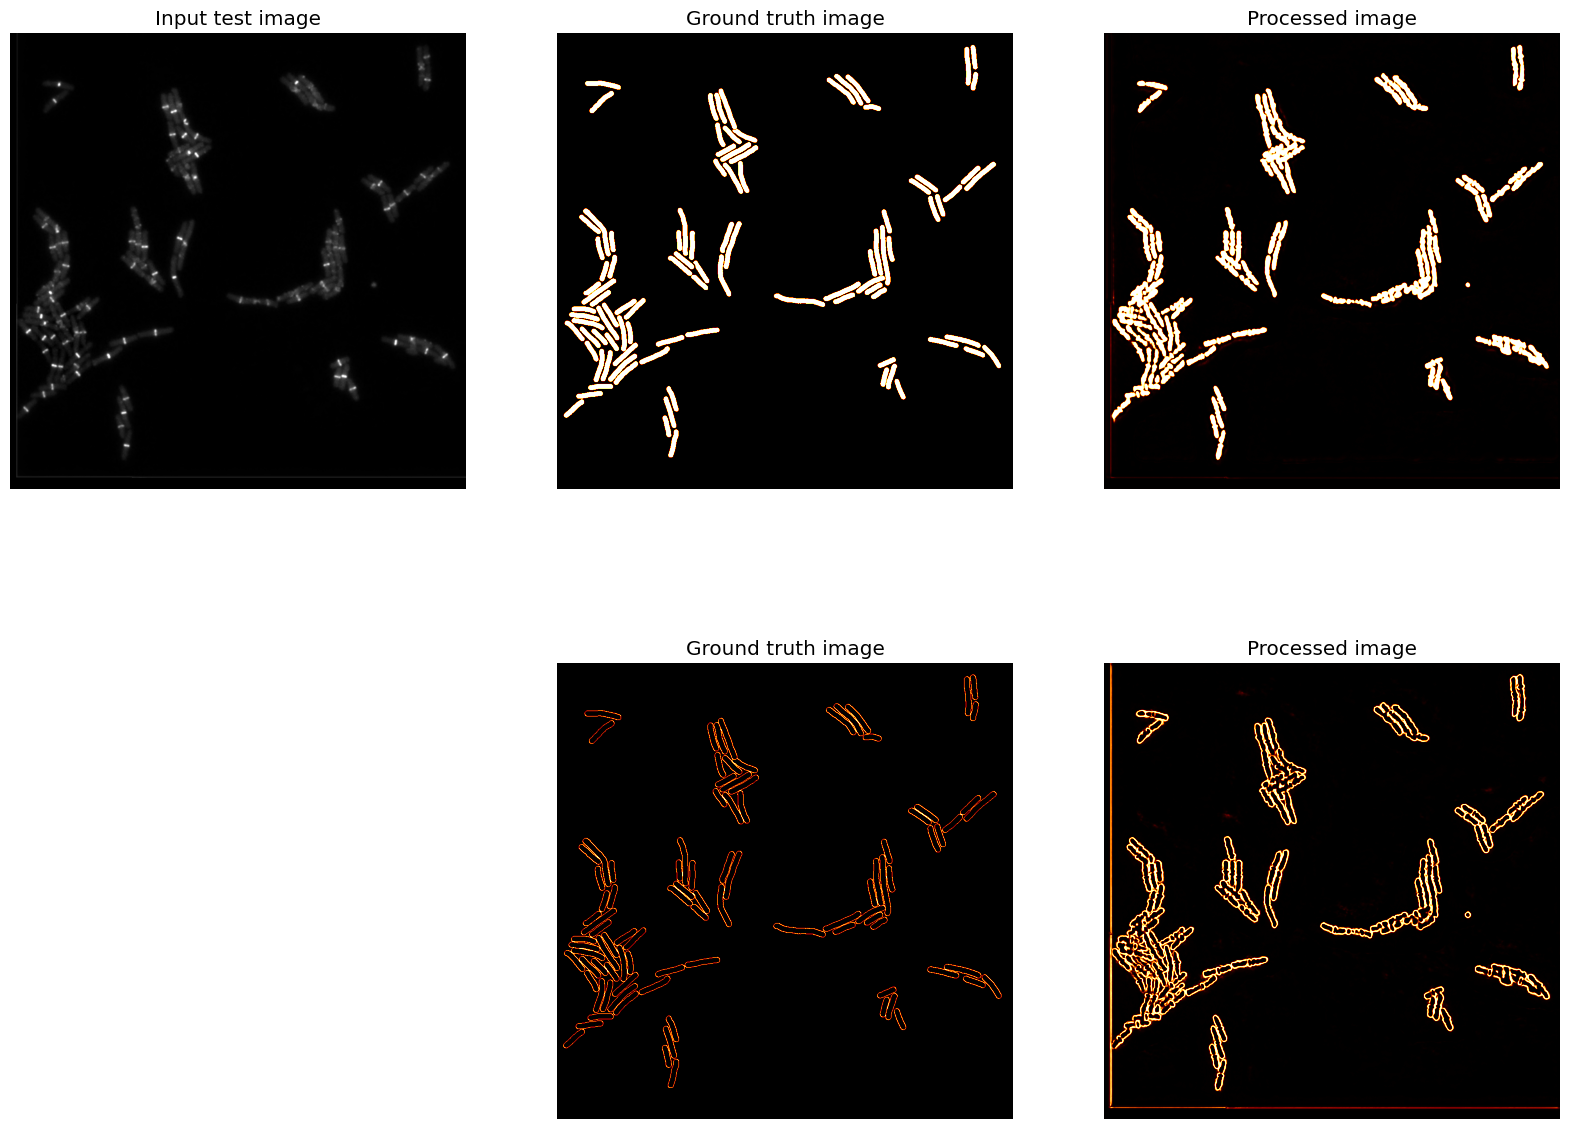

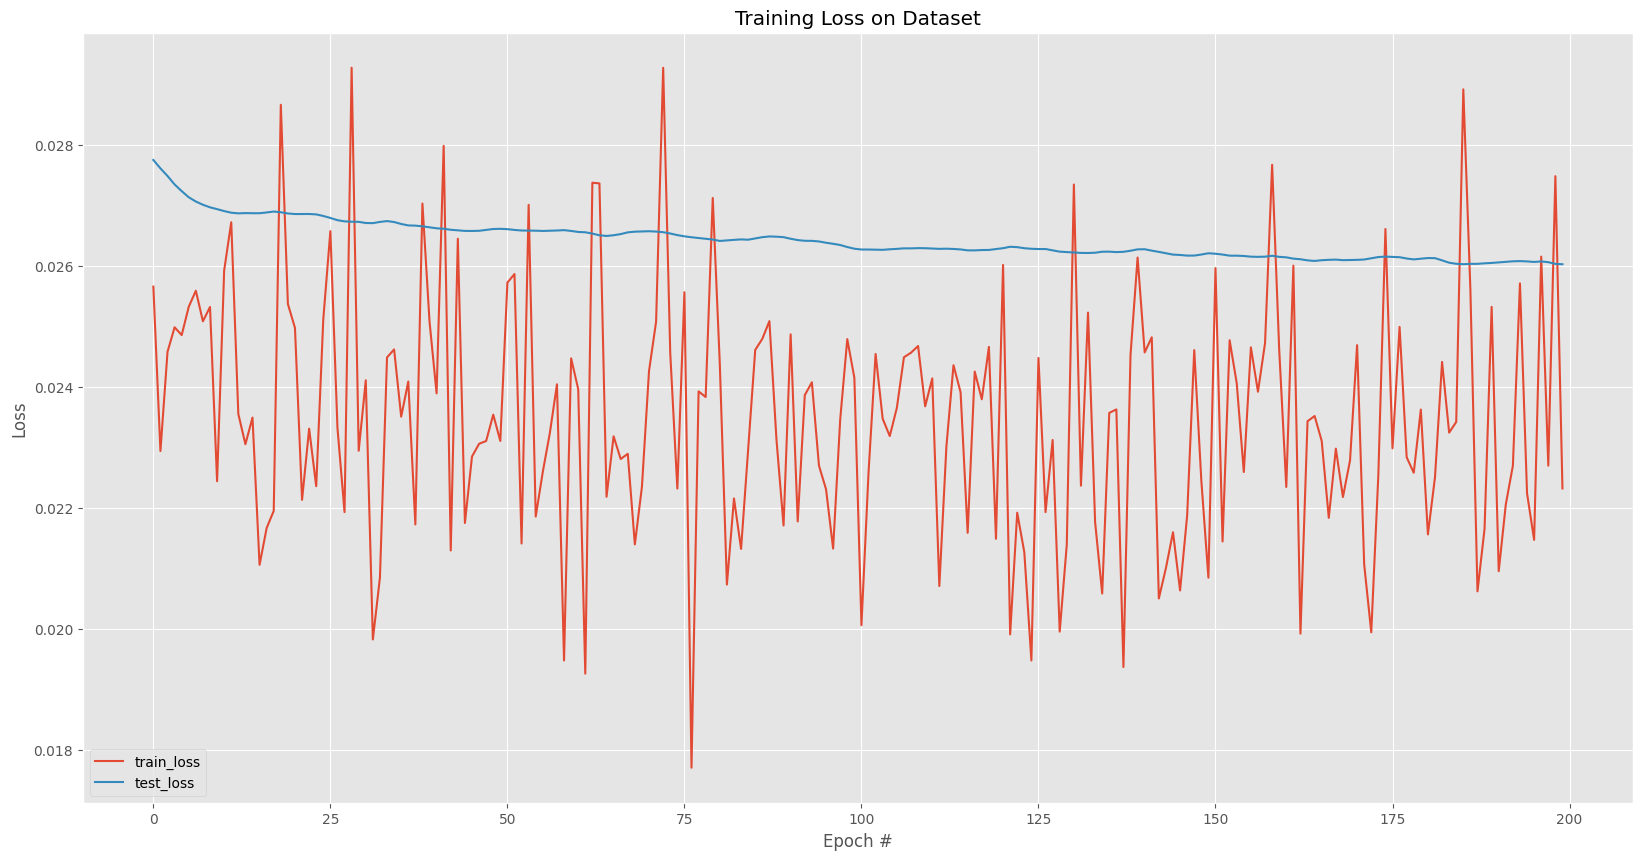

In [ ]:
#@markdown ## Set up training parameters

# Initialize learning rate, number of epochs to train for, and the batch size
INIT_LR = 0.000001 #@param {type:"number"}
NUM_EPOCHS = 200 #@param {type:"integer"}
BATCH_SIZE = 20 #@param {type:"integer"}
# Define the shape of the input and number of classes,
INPUT_IMAGE_WIDTH = 256 #@param {type:"integer"}
INPUT_IMAGE_HEIGHT = 256 #@param {type:"integer"}
CLASSES=3
# Training data files
TRAIN_IM = "/home/ocb/Documents/IH/DeepBacs/Multilabel_U-Net_dataset_B.subtilis/training/source" #@param {type:"string"}
TRAIN_MASK = "/home/ocb/Documents/IH/DeepBacs/Multilabel_U-Net_dataset_B.subtilis/training/target_boundaries" #@param {type:"string"}
# Test data files
TEST_IM = "/home/ocb/Documents/IH/DeepBacs/Multilabel_U-Net_dataset_B.subtilis/test/source" #@param {type:"string"}
TEST_MASK = "/home/ocb/Documents/IH/DeepBacs/Multilabel_U-Net_dataset_B.subtilis/test/target_boundaries" #@param {type:"string"}

#@markdown ### Path to the directory to save the new model

# Define the path to the base output directory
BASE_OUTPUT = "/home/ocb/Desktop/results" #@param {type:"string"}
os.makedirs(BASE_OUTPUT, exist_ok=True)
# Define the path to the output serialized model, model training
# plot, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, "finetuned_bioimageio.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "plot.png"])

## -----
## Release some memory
# del model_instance
# del finetuned_model
torch.cuda.empty_cache()
# gc.collect()
## -----

finetuned_model, H = finetune_bioimageio_model(model, TRAIN_IM, TRAIN_MASK, TEST_IM, TEST_MASK,
                                          BASE_OUTPUT, NUM_EPOCHS=NUM_EPOCHS, INIT_LR=INIT_LR, BATCH_SIZE=BATCH_SIZE,
                                          INPUT_IMAGE_WIDTH=INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT=INPUT_IMAGE_HEIGHT,
                                               CLASSES=3)

## Save the model in two different formats

# Save the model as a pytorch statedict
MODEL_STETEDICT_PATH = os.path.join(BASE_OUTPUT, "finetuned_bioimageio_statedict_model.pth")
torch.save(finetuned_model.cpu().state_dict(),MODEL_STETEDICT_PATH)

# Convert the model to a torchscript format and save it as torchscript
MODEL_TORCHSCRIPT_PATH = os.path.join(BASE_OUTPUT, "finetuned_bioimageio_torchscript_model.pt")
with torch.no_grad():
    # load input and expected output data
    input_data = [np.load(download(inp.test_tensor.source).path).astype("float32") for inp in model.inputs]
    input_data = [torch.from_numpy(inp) for inp in input_data]
    scripted_model = torch.jit.trace(finetuned_model.cpu(), input_data)
    scripted_model.save(MODEL_TORCHSCRIPT_PATH)

# Plot the training loss and tr=est loss
plt.style.use("ggplot")
plt.figure(figsize=(20, 10))
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(PLOT_PATH)

## **6. Create a BioImage Model Zoo model**

---

Let's recreate a model based on parts of the loaded model description from above!

`bioimageio.core` also implements functionality to create a model package compatible with the [BioImnageIO Model Spec](https://bioimage.io/docs/#/bioimageio_model_spec) ready to be shared via the [Bioimage Model Zoo](https://bioimage.io/#/).
Here, we will use this functionality to create a new model with the finetuned weights.

For this we are using some information from the previouse model.

Run the following cell to export the model

In [ ]:
# ------
# Information about the model

#@markdown ##Export the new model to the bioimage model zoo format

Trained_model_name = "My new model" #@param {type:"string"}
Trained_model_description = "Model finetuned" #@param {type:"string"}

#@markdown ### Choose a test image
path2image = "/home/ocb/Documents/IH/DeepBacs/Multilabel_U-Net_dataset_B.subtilis/test/source/test_9.tif"  #@param {type:"string"}
training_data_bioimnageio_id = "zero/dataset_u-net_2d_multilabel_deepbacs"  #@param {type:"string"}

#@markdown ### Path where the new model checkpoint is saved
BASE_OUTPUT = "/home/ocb/Desktop/results" #@param {type:"string"}
MODEL_TORCHSCRIPT_PATH = os.path.join(BASE_OUTPUT, "finetuned_bioimageio_torchscript_model.pt")
output_path = os.path.join(BASE_OUTPUT, "finetuned_bioimageio_model.zip")

#####

author_list = []
for author in model.authors:
  author_list.append(Author(name=author.name,
                            affiliation=author.affiliation,
                            github_user=author.github_user))

Trained_model_license = model.license
readme_path = model.documentation
citation_list = []
for citation in model.cite:
  citation_list.append(CiteEntry(text=citation.text,
                                 doi=citation.doi,
                                 url=citation.url))


## Define the new input

# Load the input image, reshape it and save it as a numpy file
new_input_path = f"{BASE_OUTPUT}/new_test_input.npy"
test_im = imread(path2image)
test_im = test_im[-256:, :256]
test_im = np.expand_dims(test_im, axis=(0,1))
np.save(new_input_path, np.float32(test_im))

# Define the input axes (take the ones from previous model)
input_axes = []
for axis in model.inputs[0].axes:
  if axis.id == "batch":
    input_axes.append(BatchAxis(id=axis.id,
                                 description=axis.description,
                                 type=axis.type,
                                 size=axis.size))
  elif axis.id == "channel":
    input_axes.append(ChannelAxis(id=axis.id,
                                 description=axis.description,
                                 type=axis.type,
                                 channel_names=[Identifier("raw")]))
  else: # x, y or z
    input_axes.append(SpaceInputAxis(id=axis.id,
                                      description=axis.description,
                                      type=axis.type,
                                      unit=axis.unit,
                                      scale=axis.scale,
                                      concatenable=axis.concatenable,
                                      size=axis.size))

# Define the data description (which is the data type)
data_descr = IntervalOrRatioDataDescr(type="float32")

# Define the preprocessing functions, we take the ones that were already defined
preprocessing_list = model.inputs[0].preprocessing

# Create the input tensor description
new_input_descr = InputTensorDescr(id=TensorId("raw"),
                               axes=input_axes,
                               test_tensor=FileDescr(source=new_input_path),
                               data=data_descr,
                               preprocessing=preprocessing_list
)

## Define the new output, in this step we don't have the output yet, so we are
## creating a 'fake/auxiliar' output (which is created from the input) and then once
## the model is created we will be able to create the prediction and create the real
## output with it.

# Create a temporal output
aux_new_output_path = f"{BASE_OUTPUT}/aux_new_test_output.npy"
# The output is expected to have 2 channels, then concatenate two input images on channel axis
np.save(aux_new_output_path, np.float32(np.concatenate((test_im,test_im), axis=1)))

# Define the output axes (take the ones from previous model)
output_axes = []
for axis in model.outputs[0].axes:
  if axis.id == "batch":
    output_axes.append(BatchAxis(id=axis.id,
                                 description=axis.description,
                                 type=axis.type,
                                 size=axis.size))
  elif axis.id == "channel":
    output_axes.append(ChannelAxis(id=axis.id,
                                 description=axis.description,
                                 type=axis.type,
                                 channel_names=axis.channel_names))
  else: # x, y or z
    output_axes.append(SpaceOutputAxis(id=axis.id,
                                      description=axis.description,
                                      type=axis.type,
                                      unit=axis.unit,
                                      scale=axis.scale,
                                      size=SizeReference(tensor_id=TensorId("raw"),
                                                         axis_id=axis.size.axis_id,
                                                         offset=axis.size.offset)))

# Define the posprocessing functions, we take the ones that were already defined
# postprocessing_list = model.outputs[0].postprocessing
postprocessing_list = [] # This model does not require postprocessing

# Create the output tensor description
new_output_descr = OutputTensorDescr(id=TensorId("prob"),
                                    axes=output_axes,
                                    test_tensor=FileDescr(source=aux_new_output_path),
                                    postprocessing=postprocessing_list)

# Define the training data
training_data = LinkedDataset(id=training_data_bioimnageio_id)

# Define the PyTorch architecture with the one you previously loaded
# model_source = get_architecture_source("affable-shark")
pytorch_architecture = ArchitectureFromFileDescr(
        source=download(model.weights.pytorch_state_dict.architecture.source,
                        sha256=model.weights.pytorch_state_dict.architecture.sha256).path,
        sha256=model.weights.pytorch_state_dict.architecture.sha256,
        callable=model.weights.pytorch_state_dict.architecture.callable,
        kwargs=model.weights.pytorch_state_dict.architecture.kwargs
    )

# Get PyTorch version
try:
    import torch
except ImportError:
    pytorch_version = Version("1.15")
else:
    pytorch_version = Version(torch.__version__)

# Define the weights using provided info
weights = WeightsDescr(
            torchscript=TorchscriptWeightsDescr(
                source=MODEL_TORCHSCRIPT_PATH,
                sha256=None,
                pytorch_version=torch.__version__
            )
          )

# We create the model, process the input image and create the model again with the correct output.
for i in range(2):
  # The test input and output data are passed as list because we support multiple inputs / outputs per model
  my_model_descr = ModelDescr(
      name = Trained_model_name,
      description = Trained_model_description,
      authors = author_list,
      license = Trained_model_license,
      documentation = readme_path,
      weights= weights,
      inputs = [new_input_descr],
      outputs =  [new_output_descr],
      tags=["in-silico-labeling","pytorch", "cyclegan", "conditional-gan",
            "zerocostdl4mic", "deepimagej", "actin", "dapi", "cells", "nuclei",
            "fluorescence-light-microscopy", "2d"],  # the tags are used to make models more findable on the website
      cite = citation_list,
      training_data = training_data,
      # add_deepimagej_config=True,
      )

  if i == 0:

    # Define the new input sample (taken from the new model description)
    new_input_paths = {ipt.id: download(ipt.test_tensor).path for ipt in my_model_descr.inputs}

    # The prediction pipeline expects a Sample object from bioimageio.core
    input_sample = create_sample_for_model(
        model=my_model_descr, inputs=new_input_paths, sample_id="my_demo_sample"
    )

    # Create the new prediction
    prediction = predict(model=my_model_descr, inputs=input_sample)

    # Save the new prediction on a NumPy file
    new_output_path = f"{BASE_OUTPUT}/new_test_output.npy"
    prediction_tensor = prediction.members["prob"].data
    np.save(os.path.join(new_output_path), prediction_tensor)

    # Define the posprocessing functions, we take the ones that were already defined
    # postprocessing_list = model.outputs[0].postprocessing
    postprocessing_list = [] # This model does not require postprocessing

    # Create the output tensor description
    new_output_descr = OutputTensorDescr(id=TensorId("prob"),
                          axes=output_axes,
                          test_tensor=FileDescr(source=new_output_path),
                          postprocessing=postprocessing_list)

# Check that the model works and display the result of the test
summary = test_model(my_model_descr)
summary.display()


if summary.status == "passed":
  # In case it has passed the test, save the bioimage.io model with the correct format
  save_bioimageio_package(my_model_descr, output_path=Path(output_path))
  print("The bioimage.io model was successfully exported to", output_path)
else:
  print("The bioimage.io model was exported to", output_path)
  print("Some tests of the model did not work!l.")
  print("You can still download and test the model, but it may not work as expected.")


2024-08-12 14:43:40.938 | Level 30 | bioimageio.spec._internal.field_warning:issue_warning:149 - documentation: No '# Validation' (sub)section found in documentation.md.
2024-08-12 14:43:40.943 | Level 30 | bioimageio.spec._internal.field_warning:issue_warning:149 - covers: Failed to generate cover image(s): Failed to construct cover image from shape (1, 2, 256, 256)
2024-08-12 14:43:41.045 | Level 30 | bioimageio.spec._internal.field_warning:issue_warning:149 - documentation: No '# Validation' (sub)section found in documentation.md.
2024-08-12 14:43:41.050 | Level 30 | bioimageio.spec._internal.field_warning:issue_warning:149 - covers: Failed to generate cover image(s): Failed to construct cover image from shape (1, 2, 256, 256)
2024-08-12 14:43:41.050 | INFO     | bioimageio.core._resource_tests:_test_model_inference:130 - starting 'Reproduce test outputs from test inputs'
2024-08-12 14:43:41.278 | INFO     | bioimageio.core._resource_tests:_test_model_inference_parametrized:215 - Te


|        ✔️       | bioimageio validation passed |
|       ---       |             ---              |
| source          | in-memory                    |
| format version  | model 0.5.3                  |
| bioimageio.spec | 0.5.3.2                      |
| bioimageio.core | 0.6.8                        |

|  ❓  | location |                                      detail                                     |
| --- |   ---    |                                       ---                                       |
| ✔️  |          | initialized ModelDescr to describe model 0.5.3                                  |
|     |          |                                                                                 |
| ✔️  |          | Has expected resource type                                                      |
|     |          |                                                                                 |
| ✔️  |          | Reproduce test outputs from test inputs                                         |
|     |          |                                                                                 |
| ✔️  |          | Run torchscript inference for inputs with batch_size: 1 and size parameter n: 0 |
|     |          |                                                                                 |
| ✔️  |          | Run torchscript inference for inputs with batch_size: 2 and size parameter n: 0 |
|     |          |                                                                                 |
| ✔️  |          | Run torchscript inference for inputs with batch_size: 1 and size parameter n: 1 |
|     |          |                                                                                 |
| ✔️  |          | Run torchscript inference for inputs with batch_size: 2 and size parameter n: 1 |
|     |          |                                                                                 |
| ✔️  |          | Run torchscript inference for inputs with batch_size: 1 and size parameter n: 2 |
|     |          |                                                                                 |
| ✔️  |          | Run torchscript inference for inputs with batch_size: 2 and size parameter n: 2 |
|     |          |                                                                                 |


The bioimage.io model was successfully exported to /home/ocb/Desktop/results/finetuned_bioimageio_model.zip
